In [1]:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from tqdm.notebook import tqdm_notebook
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import multiprocessing
import os
import shap

shap.initjs()
tqdm_notebook.pandas()

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


In [2]:
target_station_ids = [6005, 6022, 6296, 6027, 5004, 5012, 5024, 5805]

## Features generation functions

In [3]:
def shift(data, columns, timedelta):
    shifted_values = data[columns].shift(timedelta)
    shifted_values.columns = ["shift-{}-{}".format(timedelta, i) for i in shifted_values.columns]
    
    return shifted_values


def generate_shifted_features(data, feature_columns, timedeltas):
    shifted_features = []
    
    for timedelta in timedeltas:
        shifted_features.append(shift(data, feature_columns, timedelta))
        
    shifted_features = pd.concat(shifted_features, axis=1)

    return shifted_features

In [4]:
def trend(data, columns, timedelta):
    trend_values = data[columns].diff(timedelta)
    trend_values.columns = ["trend-{}-{}".format(timedelta, i) for i in trend_values.columns]
    
    return trend_values


def generate_trend_features(data, feature_columns, timedeltas):
    trend_features = []
    
    for timedelta in timedeltas:
        trend_features.append(trend(data, feature_columns, timedelta))
        
    trend_features = pd.concat(trend_features, axis=1)

    return trend_features

In [5]:
def aggregate(data, timedelta_days, columns, agg_function, time):
    end_time = time
    start_time = end_time - pd.Timedelta(days=(timedelta_days - 1))
    interval_data = data[start_time:end_time][columns]
    
    if interval_data.shape[0] < 1:
        return pd.Series(dtype=np.float32)
    
    agg_data = getattr(interval_data, agg_function)().round(1)
    agg_data.index = ["{}-{}-{}".format(agg_function, timedelta_days, i) for i in agg_data.index]
    
    return agg_data


def generate_aggregation_features(data, feature_columns, timedeltas, agg_function_name="mean"):
    aggregation_features = []
    
    timeline = data.reset_index().time
    for timedelta_days in timedeltas:
        agg_function = partial(aggregate, data, timedelta_days, feature_columns, agg_function_name)
        aggregation_features.append(timeline.apply(agg_function))
        
    aggregation_features = pd.concat(aggregation_features, axis=1)
    aggregation_features.index = data.index
            
    return aggregation_features

In [6]:
def generate_target(level):
    target = []

    for i in range(level.shape[0] - 10):
        X = np.expand_dims(np.arange(0, 11), 1)

        start_date = level.index[i]
        y = level.loc[start_date:start_date + pd.Timedelta(days=10)].copy()
        y -= y.iloc[0]

        if y.shape[0] != 11 or y.isna().any():
            target.append(np.nan)
        else:
            model = LinearRegression(fit_intercept=False).fit(X, y)
            target.append(model.coef_[0])
            
    target = pd.Series(target, index=level.index[:-10])
    return target

In [7]:
def process_stantion_data(stantion_data):
    level = stantion_data["level"]
    target = generate_target(level)
    
    temperature_ground = stantion_data["temperature_ground"].copy()
    temperature_ground[temperature_ground == 0.0] = 1
    
    stantion_data["temperature_air/ground"] = stantion_data["temperature_air"] / temperature_ground
    stantion_data["is_snow"] = ((stantion_data["snow"] > 0) & (stantion_data["shower"] > 0)).astype(np.float32)
    stantion_data["is_rain"] = (stantion_data["rain"] > 0).astype(np.float32)
    
    
    trend_features_1 = generate_trend_features(stantion_data,
                                             ['level', 'near_level_1', 'near_level_2', 'near_level_3', 
                                               'visibility_distance', 'humidity', 'temperature_air',
                                               'wind_speed', 'temperature_ground', 
                                              'pressure', 'temperature_air/ground'],
                                              [3, 7, 11, 15, 30, 60, 180])
    
    shift_features_1 = generate_shifted_features(stantion_data,
                                                ["humidity", "temperature_air", 
                                                 "wind_speed", "wind_direction", 
                                                 "temperature_ground", "pressure",
                                                 "temperature_air/ground"],
                                                  [3, 7, 30, 60, 180, 365])
    
    shift_features_2 = generate_shifted_features(trend_features_1,
                                                 trend_features_1.columns.tolist(),
                                                 [3, 5, 7, 11, 14, 17, 30, 60])
    
    
    agg_features_1 = generate_aggregation_features(stantion_data,
                                                  ['visibility_distance', 'temperature_air',
                                                   'wind_speed', 'wind_direction', 
                                                   'temperature_ground', 'pressure',
                                                   'temperature_air/ground'],
                                                   [3, 14, 60, 180])
    
    agg_features_2 = generate_aggregation_features(stantion_data,
                                                   ["precipitation_amount", "humidity", 
                                                    "rain", "shower", "snow", "fog", "drizzle"],
                                                   [14, 30, 60, 180],
                                                   agg_function_name="sum")  
    
    trend_features_2 = generate_trend_features(agg_features_1,
                                               agg_features_1.columns.tolist(),
                                               [3, 7, 11, 15, 30, 60, 180])
    
    trend_features_3 = generate_trend_features(agg_features_2,
                                               agg_features_2.columns.tolist(),
                                               [3, 7, 11, 15, 30, 60, 180])
    
    
    shift_features_3 = generate_shifted_features(agg_features_1,
                                               agg_features_1.columns.tolist(),
                                               [30, 60, 180, 360])
    
    shift_features_4 = generate_shifted_features(agg_features_2,
                                               agg_features_2.columns.tolist(),
                                               [30, 60, 180, 360])
    
    
    weather = generate_aggregation_features(stantion_data,
                                           ["is_snow", "is_rain", "humidity", "temperature_air",
                                            "precipitation_amount", "pressure", "wind_direction",
                                            "wind_speed"],
                                           [10],
                                           agg_function_name="mean") 
    
    weather = generate_shifted_features(weather,
                                        weather.columns.tolist(),
                                        [-10])
    
    weather.columns = ["snow", "rain", "humidity", "temperature_air",
                        "precipitation_amount", "pressure", "wind_direction",
                        "wind_speed"]
    
    
    X = pd.concat((trend_features_1, trend_features_2, trend_features_3, 
                   shift_features_1, shift_features_2, shift_features_3, shift_features_4,
                   agg_features_1, agg_features_2,
                   weather), axis=1)
    
    
    stantion_id = stantion_data["identifier"].iloc[0]
    X["identifier"] = stantion_id
    X["month"] = stantion_data.index.month
    X["day"] = stantion_data.index.day
    
    X["near_dist_1"] = stantion_data["near_dist_1"]
    X["near_dist_2"] = stantion_data["near_dist_2"]
    X["near_dist_3"] = stantion_data["near_dist_3"]
    
    X = X.iloc[:target.shape[0]]
    
    nan_indexes = X.isna().any(axis=1) | target.isna()
    drop_indexed = X.index[nan_indexes]
    
    X = X.drop(drop_indexed)
    target = target.drop(drop_indexed)
    level = level.drop(drop_indexed)
    
    return stantion_id, (X, target, level)

In [8]:
def process_data(data):
    stantion_ids = set([i[0] for i in data.index])
    
    splited_data = []
    for stantion_id in stantion_ids:
        stantion_data = data.loc[stantion_id]
        stantion_data["identifier"] = stantion_id
        
        splited_data.append(stantion_data)
        
    pool = multiprocessing.Pool(os.cpu_count())
    data_processor = pool.imap(process_stantion_data, splited_data)
#     data_processor = (process_stantion_data(i) for i in splited_data)
    data_processor = tqdm_notebook(data_processor, total=len(splited_data))
    
    processed_data = dict(data_processor)
    
    pool.close()
    return processed_data

## Validation functions

In [43]:
def get_model_predict(p, y):
    predict = np.arange(1, 11) * p
    if isinstance(y, pd.Series):
        predict += y.iloc[0]
        predict = pd.Series(predict, index=y.index[1:])
    else:
        predict += y[0]
        
    return predict


def calculate_model_mse(p, y):
    y = np.array(y)
    predict = get_model_predict(p, y)
    
    return np.sqrt(np.mean((y[1:] - predict)**2))


def print_model_deviation_rate(deviations):
    print("Deviations rate:")
    deviations = np.array(deviations)
    for i in [10, 15, 50, 60, 70, 80, 90, 100, 150, 170, 200, 300, 500, 1000]:
        deviation_rate = round(((deviations > i).sum() / deviations.shape[0]) * 100)
        print(">{} cm -> {}%".format(i, deviation_rate))

        
def plot_model_result(p_model, p_target, y):
    mse_model = round(calculate_model_mse(p_model, y), 2)
    mse_target = round(calculate_model_mse(p_target, y), 2)
    
    predict_model = get_model_predict(p_model, y)
    predict_target = get_model_predict(p_target, y)
    if isinstance(y, pd.Series):
        y = y.iloc[1:]
    else:
        y = y[1:]
        
        
    p_model = round(p_model, 2)
    p_target = round(p_target, 2)
    
    plt.figure(figsize=(15,4))
    plt.title("RMSE MODEL: {}; P MODEL = {}  |  RMSE TARGET: {}; P TARGET = {}".format(mse_model, 
                                                                                     p_model, 
                                                                                     mse_target, 
                                                                                     p_target))
    plt.plot(predict_model, color="red")
    plt.plot(predict_target, color="green")
    plt.plot(y, color="blue")
    
    
def calculate_model_mse_on_dataset(P, Y):
    P = P.tolist()
    errors = pd.Series(dtype=np.float32)
    
    for i in range(Y.shape[0] - 10):
        start_index = Y.index[i]
        end_index = start_index + pd.Timedelta(days=10)
        
        p = P[i]
        y = Y.loc[start_index:end_index]
        
        if y.shape[0] != 11:
            continue
        
        predict = get_model_predict(p, y)
        _errors = (y[1:] - predict) ** 2
        errors = pd.concat((errors, _errors))
    
    return np.sqrt(np.mean(errors))


def print_model_devation_rate_on_dataset(P, Y):
    P = P.tolist()
    errors = pd.Series(dtype=np.float32)
    
    
    for i in range(Y.shape[0] - 10):
        start_date = Y.index[i]
        end_date = start_date + pd.Timedelta(days=10)
        
        p = P[i]
        y = Y.loc[start_date:end_date]
        
        if y.shape[0] != 11:
            continue
        
        predict = get_model_predict(p, y)
        _errors = np.abs(y[1:] - predict)
        errors = pd.concat((errors, _errors))
        
    print_model_deviation_rate(errors)

In [44]:
def validation_report(model, X_val, Y_val, level_val, stantion_id=None, plot_dates=[]):
    print("\n\n" + "-" * 50 + "\n")
    if stantion_id is None:
        print("--- MODEL VALIDATION REPORT ---\n")
    else:
        print("--- MODEL VALIDATION REPORT FOR STANTION {} ---\n".format(stantion_id))
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap_values = pd.DataFrame(shap_values, index=X_val.index)
    
    predicted_P = model.predict(X_val)
    predicted_P = pd.Series(predicted_P, index=Y_val.index)

    model_mse = calculate_model_mse_on_dataset(predicted_P, level_val)
    target_mse = calculate_model_mse_on_dataset(Y_val, level_val)

    print("Model RMSE:", model_mse)
    print("Target RMSE:", target_mse, "\n")
    print_model_devation_rate_on_dataset(predicted_P, level_val)
    
    for date in plot_dates:
        start_date = pd.to_datetime(date, format="%d.%m.%Y")
        end_date = start_date + pd.Timedelta(days=10)

        p_model =  predicted_P.loc[start_date]
        p_target =  Y_val.loc[start_date]
        y = level_val.loc[start_date: end_date]

        shap_v = shap_values.loc[start_date].values
        x = X_val.loc[start_date]

        plot_model_result(p_model, p_target, y)
        shap.force_plot(explainer.expected_value, shap_v, x, matplotlib=True)
        plt.show()
    
    
    shap.summary_plot(shap_values.values, X_val)
    
    return {"model_mse": model_mse}

## Training function

In [45]:
def train(data, 
          split_date="01.01.2013", 
          plot_training=True, 
          plot_validation_report=True,
          validation_plot_dates=[],
          model_config={},
          target_station_ids=[],
          using_features=None):
    
    X = []
    target = []
    
    for stantion_id, (x, y, _) in data.items():
        X.append(x)
        target.append(y)
        
    X = pd.concat(X)
    
    if using_features is not None:
        X = X[using_features]
    
    target = pd.concat(target)
    
    start = X.index[0]
    split_date = pd.to_datetime(split_date, format="%d.%m.%Y")
    end = X.index[-1]
    
    train_mask = X.index.to_series().between(start, split_date)
    val_mask = X.index.to_series().between(split_date + pd.Timedelta(days=1), end)
    
    X_train = X.loc[train_mask]
    Y_train = target.loc[train_mask]

    X_val = X.loc[val_mask]
    Y_val = target.loc[val_mask]
        
    model = CatBoostRegressor(**model_config)

    model.fit(X_train, Y_train, eval_set=(X_val, Y_val), 
              verbose=False, plot=plot_training)
    
    
    mean_mse = 0
    
    if plot_validation_report:
        print("Start validation...")
        for stantion_id in tqdm_notebook(target_station_ids):
            _, _, level = data[stantion_id]
            stantion_mask = (X_val["identifier"] == stantion_id)

            stantion_X_val = X_val[stantion_mask]
            stantion_Y_val = Y_val[stantion_mask]

            stantion_level_val = level.loc[stantion_X_val.index]

            report = validation_report(model, 
                                      stantion_X_val, stantion_Y_val, stantion_level_val, 
                                      stantion_id=stantion_id,
                                      plot_dates=validation_plot_dates)
            
            mean_mse += report["model_mse"]
    
    mean_mse = mean_mse / len(target_station_ids)
    print("MEAN MODEL RMSE:", mean_mse)
    feature_importances = sorted(zip(model.feature_importances_, model.feature_names_), reverse=True)[:100]
    
    plt.figure(figsize=(15,40))
    plt.title("Feature importances")
    plt.barh([i[1] for i in feature_importances], 
             [i[0] for i in feature_importances],
             align='center')
    plt.show()
    
    return model

## Prepare data

In [12]:
data = pd.read_csv("datasets/final_dataset.csv")
data["time"] = pd.to_datetime(data["time"])

data = data.set_index(["identifier", "time"])
data = data.sort_index()

In [13]:
processed_data = process_data(data)

In [69]:
using_features = ['trend-3-level',
 'trend-180-level',
 'identifier',
 'trend-3-near_level_2',
 'trend-7-level',
 'month',
 'trend-3-near_level_3',
 'trend-30-mean-60-temperature_air',
 'trend-60-level',
 'trend-60-mean-60-temperature_air',
 'shift-3-trend-60-level',
 'shift-60-trend-180-level',
 'shift-30-trend-180-level',
 'shift-3-trend-3-level',
 'trend-11-level',
 'near_dist_2',
 'trend-15-level',
 'shift-180-mean-180-pressure',
 'trend-30-level',
 'shift-3-trend-15-level',
 'shift-17-trend-180-level',
 'shift-14-trend-180-level',
 'shift-30-mean-180-temperature_air',
 'shift-3-trend-7-level',
 'near_dist_3',
 'near_dist_1',
 'shift-60-mean-180-pressure',
 'shift-30-mean-60-temperature_air',
 'shift-3-trend-180-level',
 'temperature_air',
 'shift-7-trend-60-level',
 'shift-60-sum-180-precipitation_amount',
 'shift-60-trend-60-level',
 'shift-11-trend-60-near_level_1',
 'shift-60-mean-180-temperature_air',
 'trend-180-mean-180-temperature_air',
 'shift-11-trend-180-level',
 'shift-30-sum-180-precipitation_amount',
 'trend-3-near_level_1',
 'pressure',
 'shift-5-trend-60-level',
 'trend-60-mean-180-temperature_air',
 'trend-180-pressure',
 'shift-17-trend-60-level',
 'trend-60-mean-14-temperature_air',
 'trend-15-mean-60-temperature_air',
 'shift-3-trend-30-level',
 'shift-14-trend-60-near_level_1',
 'mean-14-temperature_air',
 'trend-7-sum-60-shower',
 'trend-11-mean-180-temperature_air',
 'shift-360-sum-180-humidity',
 'shift-7-trend-180-level',
 'trend-30-mean-180-pressure',
 'shift-180-mean-180-temperature_air',
 'trend-7-sum-30-shower',
 'trend-180-mean-60-temperature_air',
 'trend-7-near_level_3',
 'shift-5-trend-15-level',
 'trend-3-sum-180-rain',
 'shift-180-sum-30-precipitation_amount',
 'shift-180-mean-60-temperature_air',
 'trend-7-mean-180-temperature_air',
 'shift-180-sum-30-snow',
 'trend-180-mean-14-temperature_air',
 'sum-14-humidity',
 'trend-60-sum-60-humidity',
 'shift-180-mean-60-pressure',
 'trend-11-near_level_2',
 'trend-15-mean-180-temperature_air',
 'shift-17-trend-30-level',
 'trend-11-mean-60-temperature_air',
 'trend-60-near_level_1',
 'trend-3-sum-30-precipitation_amount',
 'trend-180-mean-14-pressure',
 'shift-14-trend-30-level',
 'mean-60-pressure',
 'trend-7-sum-180-rain',
 'trend-180-sum-60-humidity',
 'trend-7-mean-180-pressure',
 'shift-360-sum-180-precipitation_amount',
 'shift-30-trend-60-level',
 'trend-3-sum-60-humidity',
 'shift-5-trend-180-level',
 'trend-15-sum-60-shower',
 'shift-3-trend-11-level',
 'trend-180-mean-180-wind_speed',
 'trend-30-near_level_1',
 'shift-60-mean-14-temperature_air',
 'trend-30-mean-180-temperature_air',
 'shift-180-sum-14-precipitation_amount',
 'mean-3-temperature_air/ground',
 'shift-5-trend-180-temperature_air',
 'trend-11-sum-60-shower',
 'trend-180-near_level_1',
 'trend-11-sum-180-rain',
 'shift-360-mean-180-pressure',
 'shift-7-trend-15-level',
 'shift-30-mean-180-pressure',
 'shift-60-mean-60-pressure',
 'shift-30-trend-180-near_level_2',
 'trend-3-sum-60-precipitation_amount',
 'trend-60-sum-180-humidity',
 'trend-7-sum-14-shower',
 'shift-14-trend-60-level',
 'sum-30-humidity',
 'trend-60-mean-60-wind_direction',
 'shift-11-trend-11-level',
 'shift-30-mean-60-pressure',
 'trend-11-near_level_1',
 'trend-180-mean-3-pressure',
 'trend-15-mean-180-pressure',
 'trend-7-sum-180-shower',
 'trend-60-mean-180-temperature_ground',
 'trend-7-near_level_2',
 'shift-30-mean-14-temperature_air',
 'shift-30-sum-180-shower',
 'humidity',
 'shift-180-sum-180-precipitation_amount',
 'shift-180-mean-14-pressure',
 'shift-360-mean-14-temperature_air',
 'mean-180-wind_speed',
 'rain',
 'shift-17-trend-11-level',
 'trend-30-mean-180-visibility_distance',
 'precipitation_amount',
 'trend-180-mean-3-temperature_air',
 'trend-11-mean-180-pressure',
 'trend-15-near_level_2',
 'shift-360-mean-14-pressure',
 'trend-30-mean-180-temperature_ground',
 'mean-3-pressure',
 'shift-60-sum-180-humidity',
 'trend-180-sum-14-rain',
 'shift-180-mean-60-wind_speed',
 'trend-11-sum-60-humidity',
 'shift-17-trend-15-level',
 'shift-3-trend-3-near_level_2',
 'trend-11-mean-60-wind_direction',
 'shift-17-trend-60-near_level_1',
 'trend-11-near_level_3',
 'shift-14-trend-7-level',
 'mean-180-pressure',
 'trend-180-mean-60-temperature_ground',
 'trend-3-mean-180-pressure',
 'trend-30-sum-60-humidity',
 'trend-3-sum-180-precipitation_amount',
 'shift-30-mean-180-wind_speed',
 'shift-180-sum-60-snow',
 'trend-180-sum-14-shower',
 'trend-15-sum-180-rain',
 'trend-15-near_level_1',
 'trend-15-sum-60-humidity',
 'shift-180-sum-60-precipitation_amount',
 'shift-60-mean-180-temperature_ground',
 'trend-11-mean-180-temperature_ground',
 'shift-3-trend-60-near_level_3',
 'shift-30-trend-180-temperature_ground',
 'shift-30-trend-11-level',
 'shift-60-mean-14-visibility_distance',
 'trend-180-mean-60-pressure',
 'mean-60-wind_speed',
 'shift-11-trend-30-level',
 'trend-15-mean-14-temperature_air/ground',
 'trend-60-mean-60-temperature_ground',
 'shift-7-trend-60-near_level_1',
 'trend-60-sum-14-humidity',
 'trend-180-temperature_air',
 'shift-360-sum-14-humidity',
 'trend-3-sum-14-humidity',
 'trend-11-humidity',
 'shift-17-trend-60-near_level_2',
 'trend-180-mean-14-wind_direction',
 'sum-180-shower',
 'shift-180-mean-14-temperature_ground',
 'trend-180-sum-60-snow',
 'mean-14-wind_direction',
 'trend-11-sum-180-shower',
 'shift-60-mean-3-temperature_air',
 'trend-15-mean-180-temperature_ground',
 'shift-60-sum-180-fog',
 'shift-17-trend-180-temperature_ground',
 'trend-180-mean-3-temperature_ground',
 'shift-7-trend-30-level',
 'trend-60-mean-60-pressure',
 'trend-60-mean-3-temperature_air',
 'shift-180-mean-14-temperature_air',
 'trend-30-sum-14-humidity',
 'mean-14-pressure',
 'trend-30-sum-30-humidity',
 'shift-14-trend-180-temperature_ground',
 'trend-3-sum-30-shower',
 'trend-7-sum-180-precipitation_amount',
 'shift-180-mean-180-wind_speed',
 'shift-360-sum-30-humidity',
 'trend-11-sum-30-humidity',
 'shift-180-sum-180-rain',
 'trend-180-sum-14-fog',
 'trend-180-mean-60-visibility_distance',
 'trend-15-mean-14-wind_direction',
 'trend-60-sum-14-shower',
 'shift-60-sum-30-snow',
 'trend-3-mean-180-temperature_air',
 'shift-30-sum-60-snow',
 'shift-5-trend-11-level',
 'trend-15-sum-30-humidity',
 'shift-360-sum-30-snow',
 'shift-60-mean-60-wind_direction',
 'shift-180-sum-180-fog',
 'shift-30-sum-30-precipitation_amount',
 'shift-3-trend-180-temperature_ground',
 'trend-60-sum-180-snow',
 'shift-180-temperature_ground',
 'shift-180-mean-14-visibility_distance',
 'trend-60-near_level_2',
 'shift-30-sum-60-precipitation_amount',
 'trend-11-sum-180-fog',
 'sum-14-shower',
 'sum-30-fog',
 'shift-17-trend-180-temperature_air',
 'trend-30-mean-3-pressure',
 'shift-60-sum-60-fog',
 'shift-180-sum-180-humidity',
 'shift-30-trend-15-level',
 'shift-60-sum-14-humidity',
 'trend-15-mean-180-wind_direction',
 'trend-15-humidity',
 'mean-60-temperature_ground',
 'shift-30-sum-60-shower',
 'trend-3-mean-14-pressure',
 'trend-30-sum-60-fog',
 'mean-180-temperature_ground',
 'trend-180-sum-30-humidity',
 'shift-360-mean-60-pressure',
 'trend-15-mean-3-pressure',
 'shift-60-mean-14-wind_speed',
 'shift-14-trend-11-level',
 'trend-180-mean-60-temperature_air/ground',
 'shift-180-mean-180-temperature_ground',
 'trend-7-sum-14-humidity',
 'shift-5-trend-30-level',
 'trend-30-mean-60-visibility_distance',
 'trend-180-sum-60-precipitation_amount',
 'shift-360-mean-180-temperature_air',
 'trend-11-sum-30-shower',
 'trend-180-mean-180-temperature_ground',
 'trend-60-mean-180-visibility_distance',
 'trend-7-sum-180-fog',
 'trend-180-sum-30-precipitation_amount',
 'trend-180-mean-14-temperature_ground',
 'snow']

## Train model

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Start validation...




--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 6005 ---

Model RMSE: 59.38068091544269
Target RMSE: 28.63146552879636 

Deviations rate:
>10 cm -> 53.0%
>15 cm -> 43.0%
>50 cm -> 18.0%
>60 cm -> 14.0%
>70 cm -> 12.0%
>80 cm -> 9.0%
>90 cm -> 8.0%
>100 cm -> 7.0%
>150 cm -> 4.0%
>170 cm -> 3.0%
>200 cm -> 2.0%
>300 cm -> 1.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


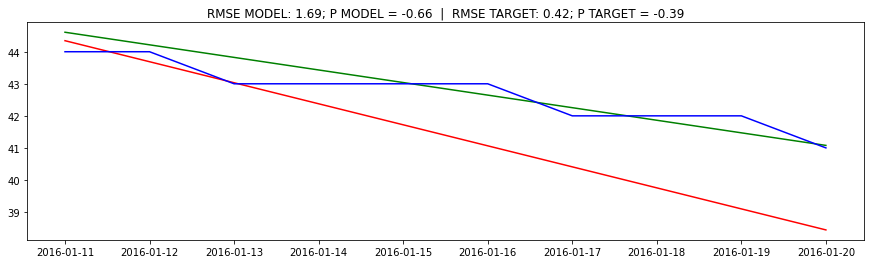

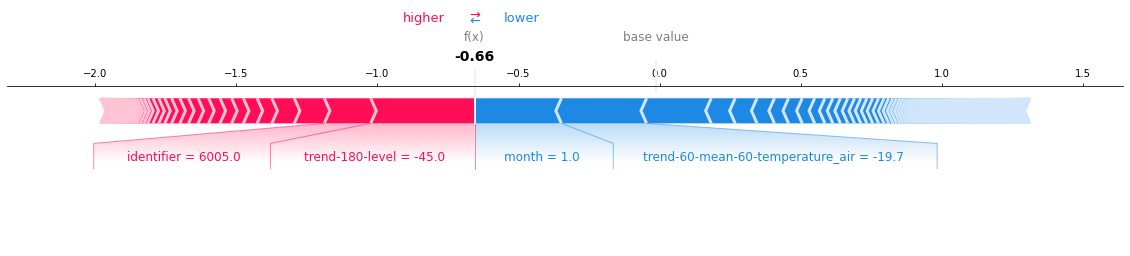

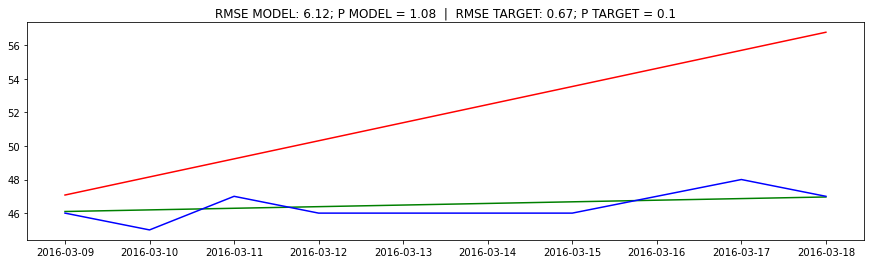

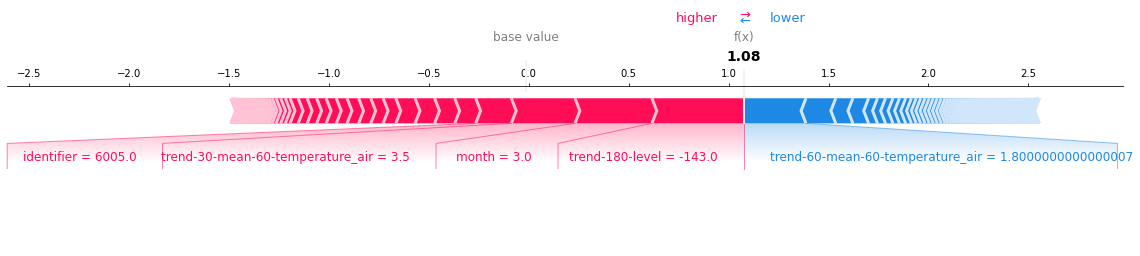

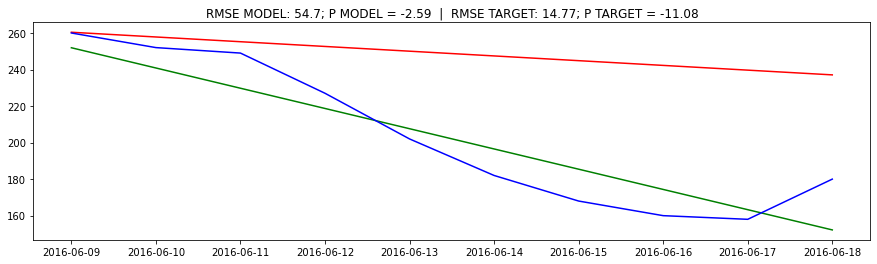

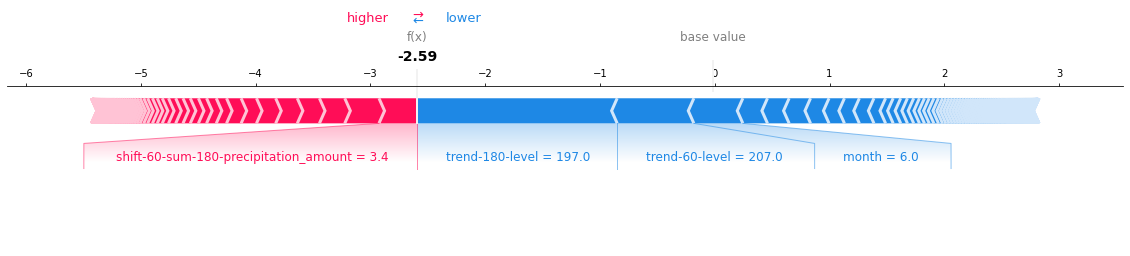

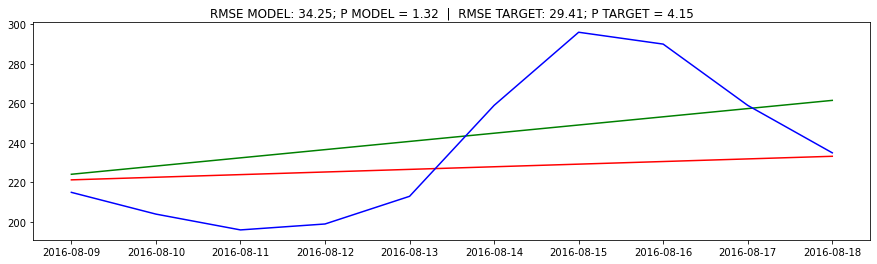

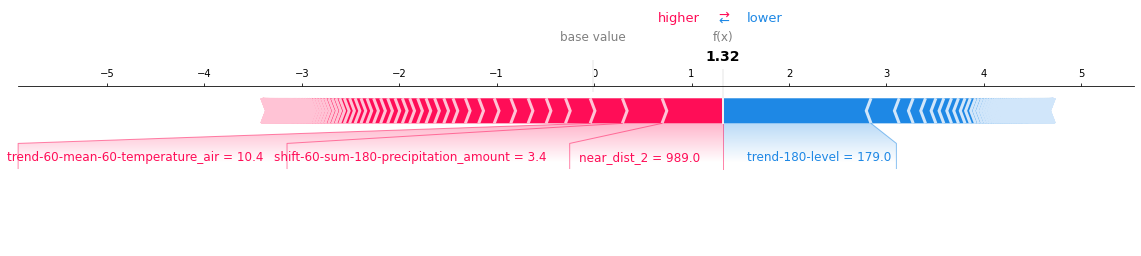

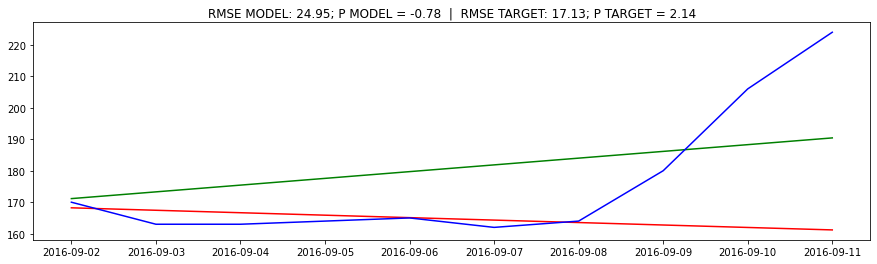

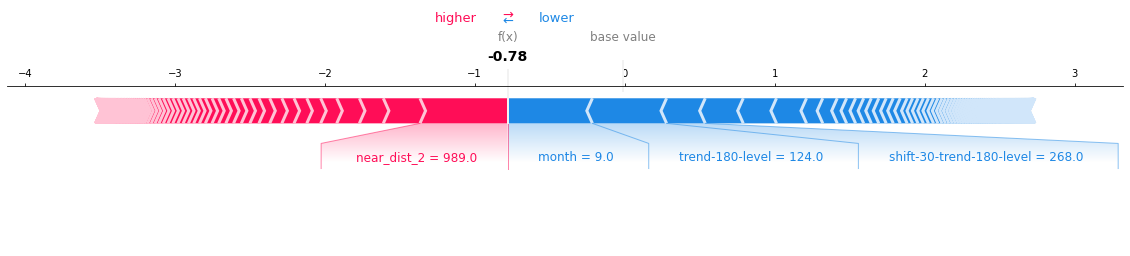

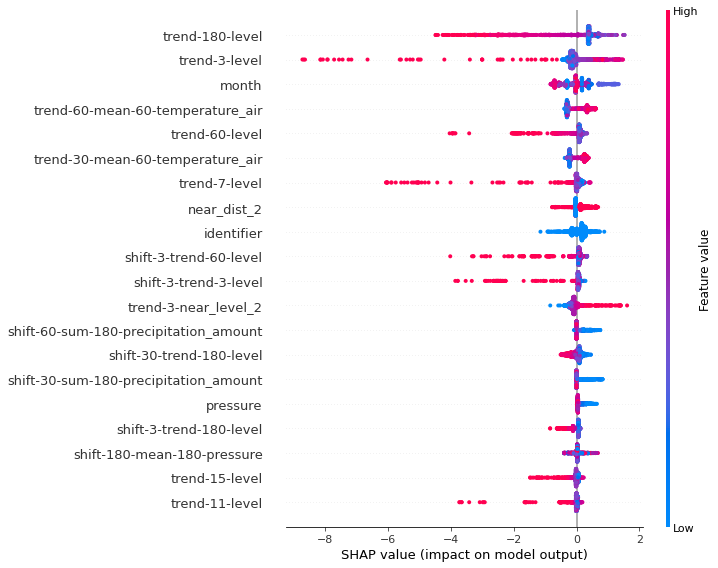



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 6022 ---

Model RMSE: 52.44781654274022
Target RMSE: 22.954917802940162 

Deviations rate:
>10 cm -> 58.0%
>15 cm -> 48.0%
>50 cm -> 20.0%
>60 cm -> 16.0%
>70 cm -> 13.0%
>80 cm -> 10.0%
>90 cm -> 8.0%
>100 cm -> 7.0%
>150 cm -> 3.0%
>170 cm -> 2.0%
>200 cm -> 1.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


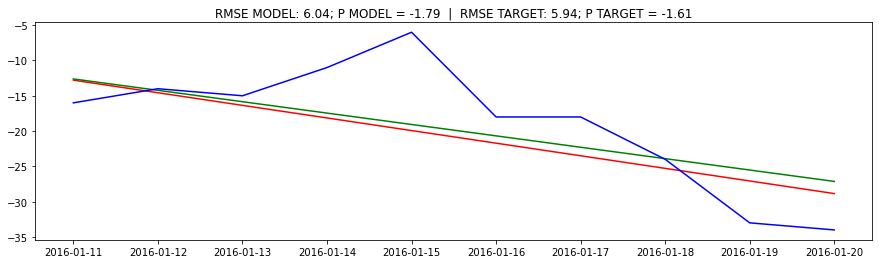

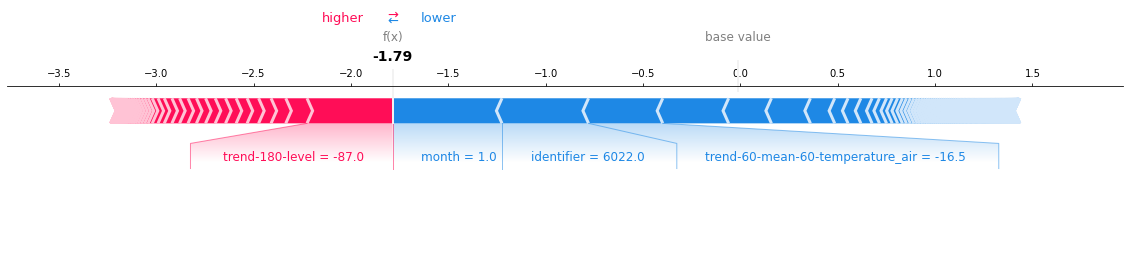

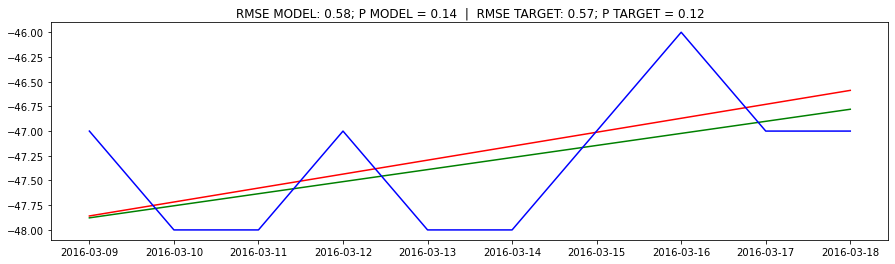

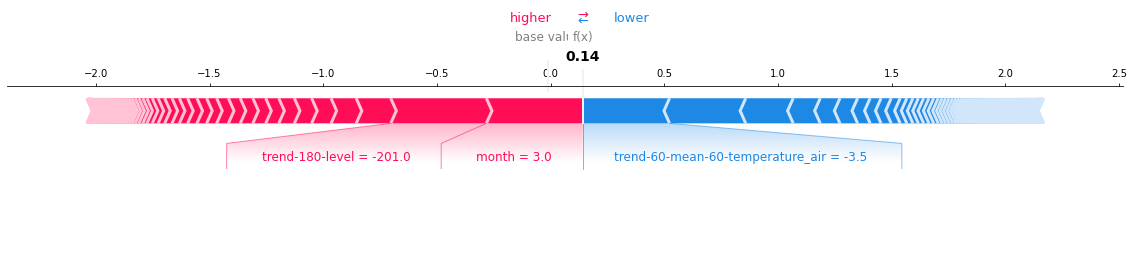

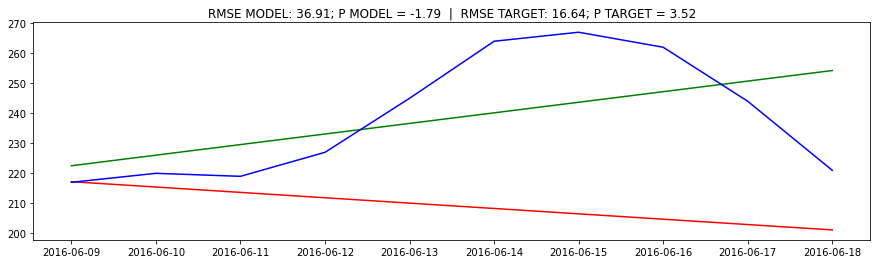

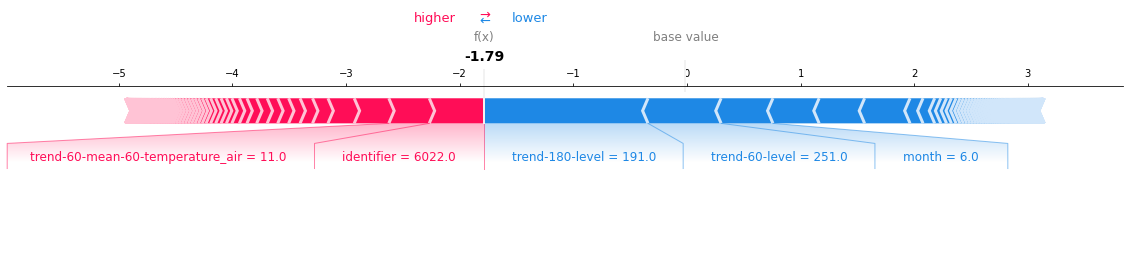

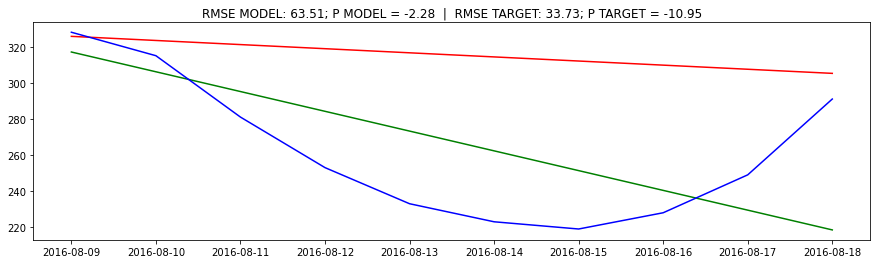

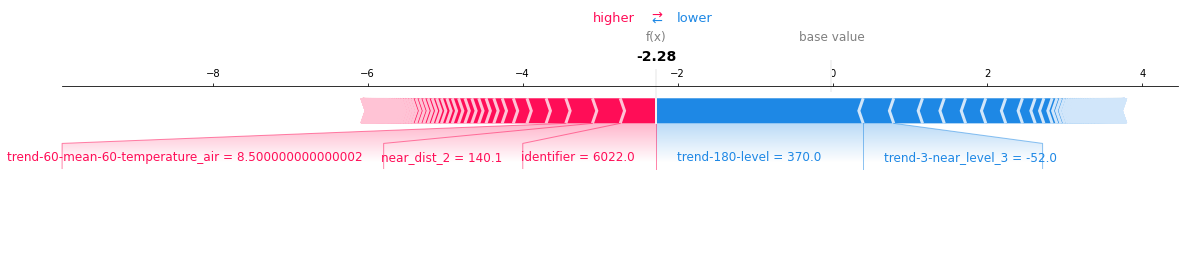

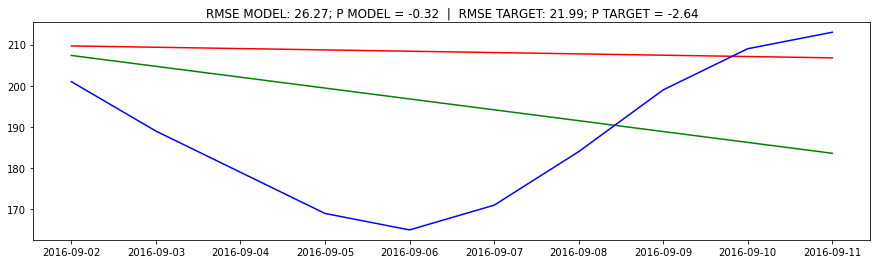

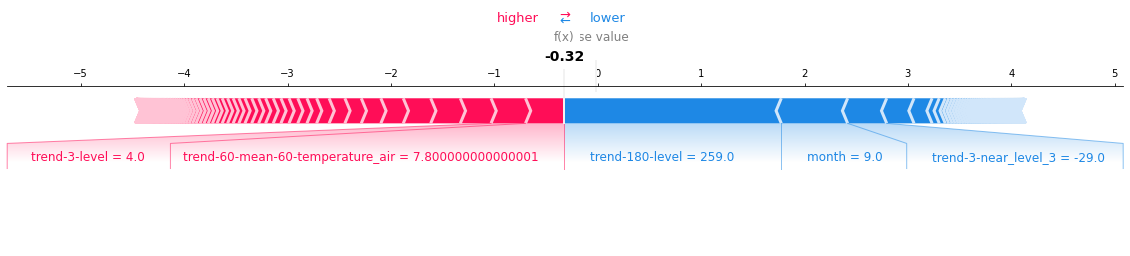

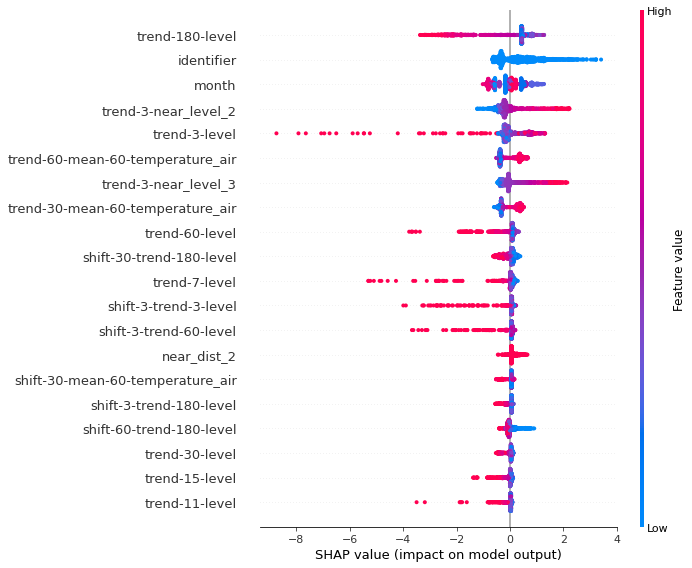



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 6296 ---

Model RMSE: 51.765722079814104
Target RMSE: 21.392626762398738 

Deviations rate:
>10 cm -> 61.0%
>15 cm -> 49.0%
>50 cm -> 19.0%
>60 cm -> 15.0%
>70 cm -> 12.0%
>80 cm -> 10.0%
>90 cm -> 9.0%
>100 cm -> 8.0%
>150 cm -> 3.0%
>170 cm -> 2.0%
>200 cm -> 1.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


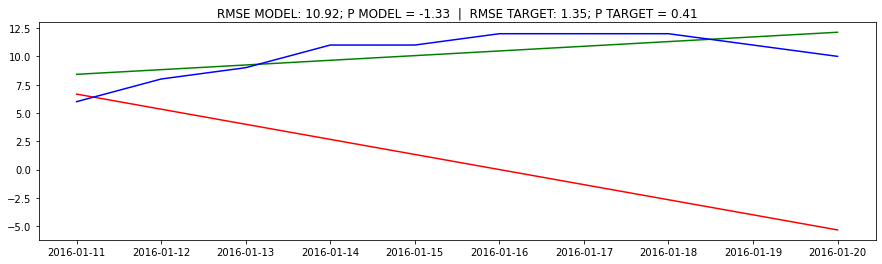

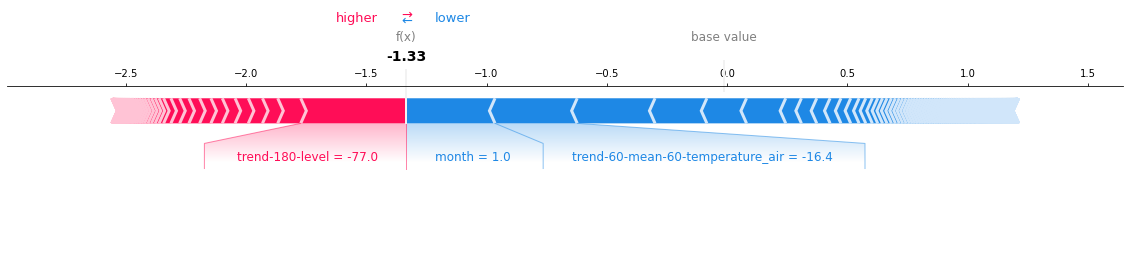

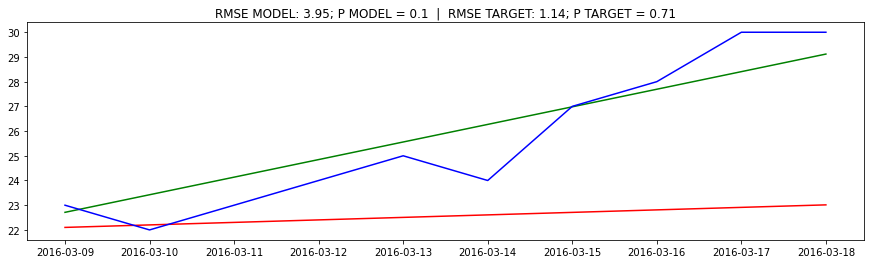

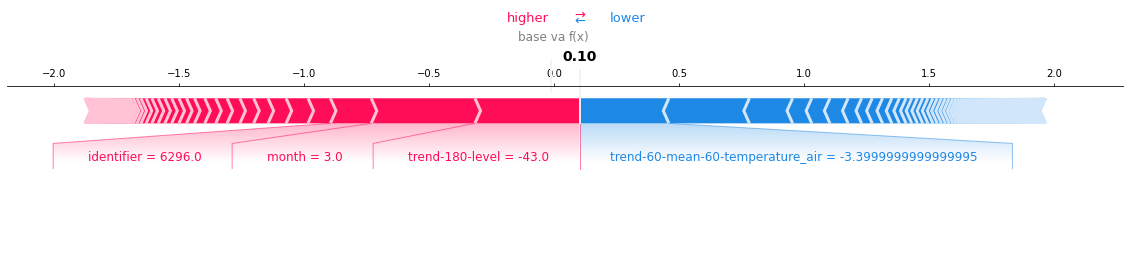

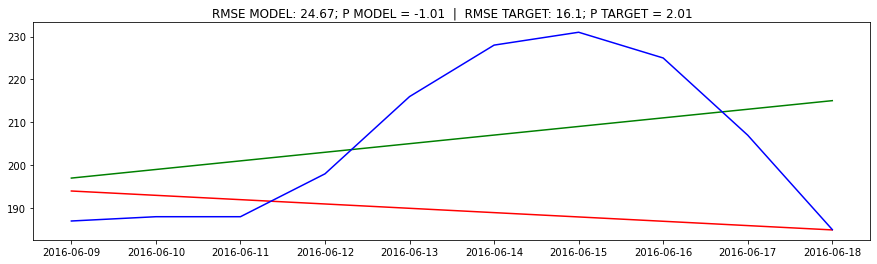

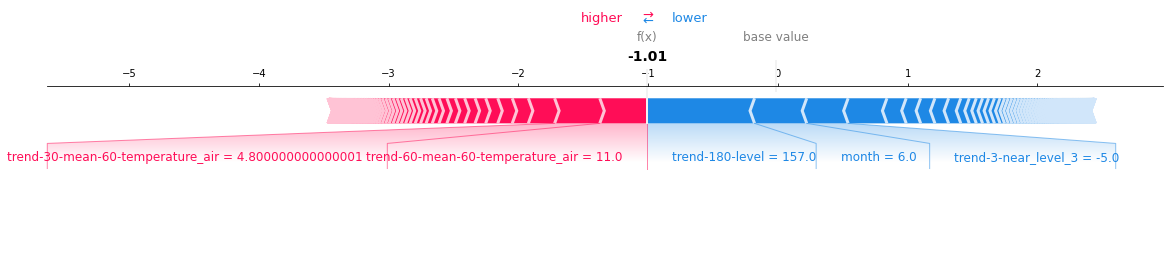

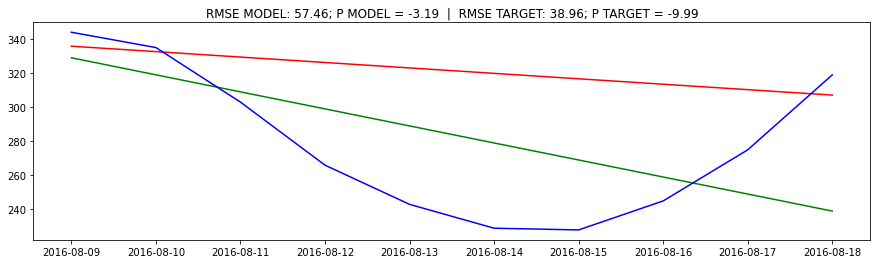

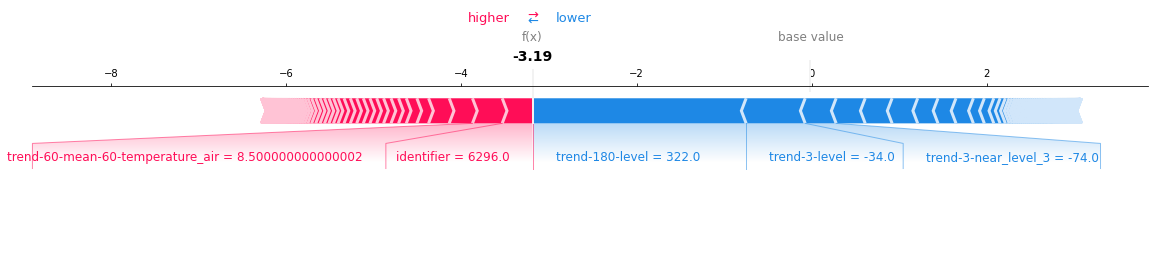

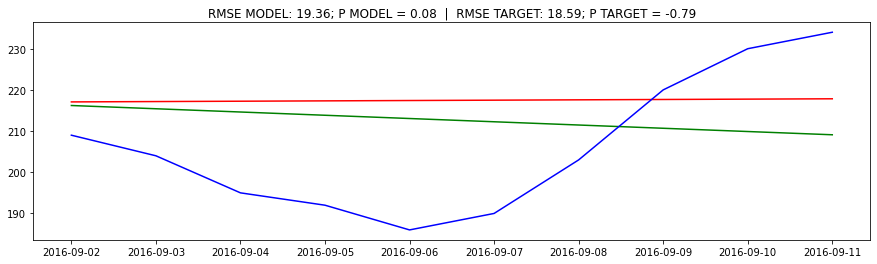

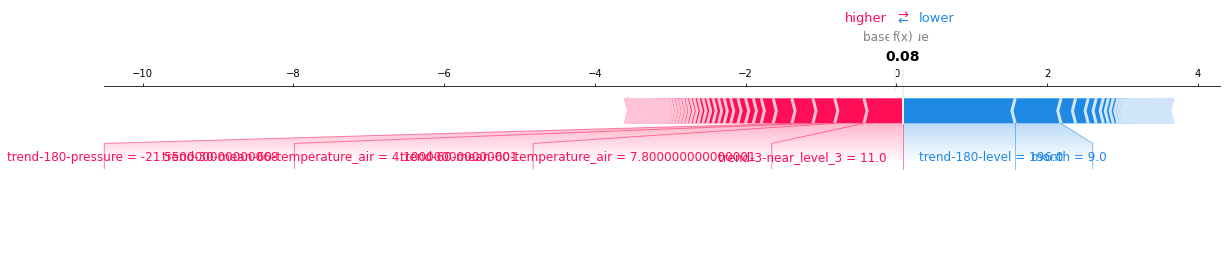

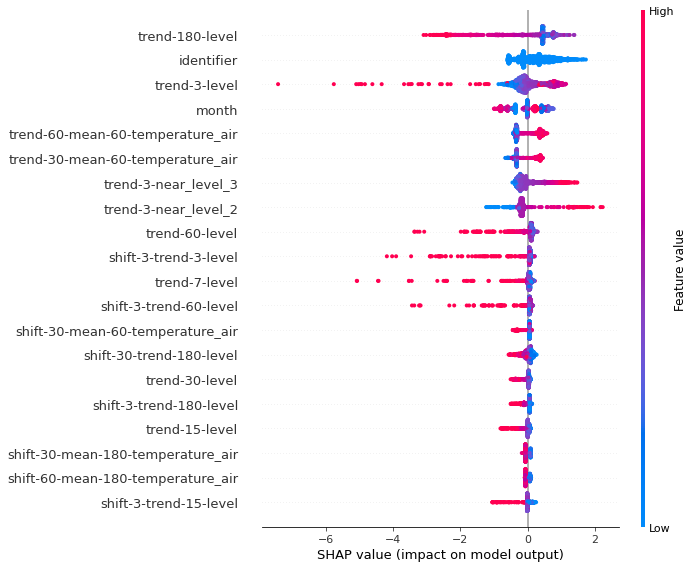



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 6027 ---

Model RMSE: 55.96119864318257
Target RMSE: 20.777534349349644 

Deviations rate:
>10 cm -> 66.0%
>15 cm -> 55.0%
>50 cm -> 22.0%
>60 cm -> 18.0%
>70 cm -> 14.0%
>80 cm -> 12.0%
>90 cm -> 11.0%
>100 cm -> 9.0%
>150 cm -> 4.0%
>170 cm -> 2.0%
>200 cm -> 1.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


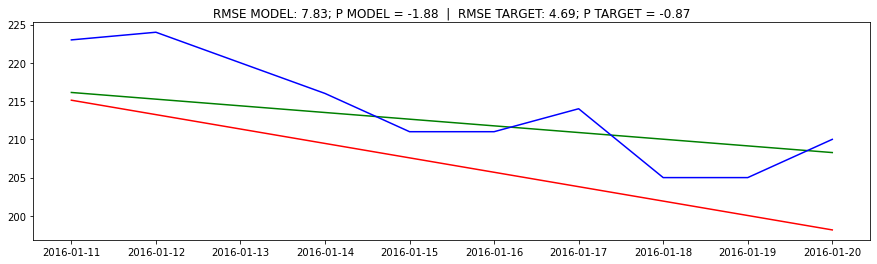

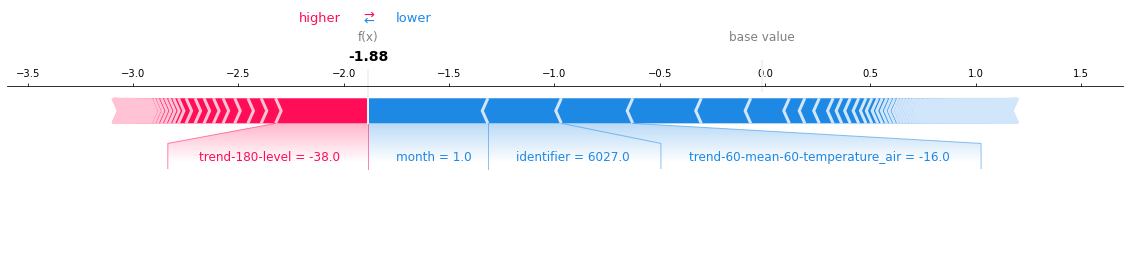

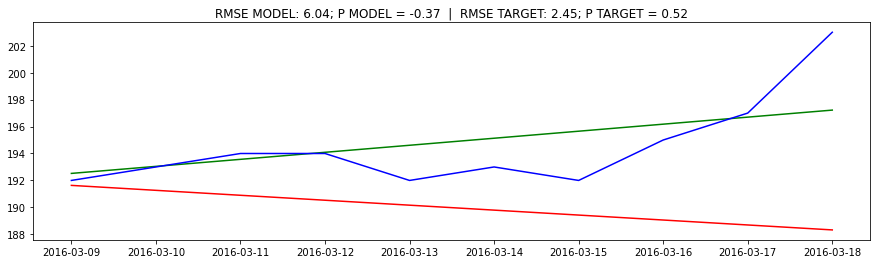

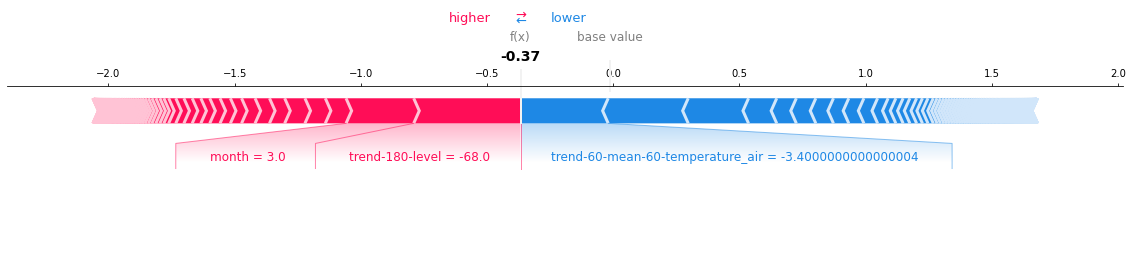

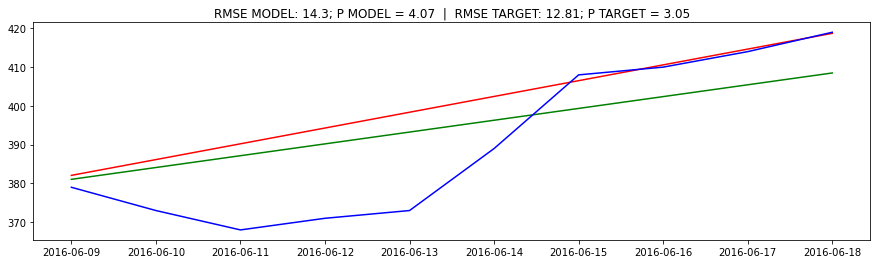

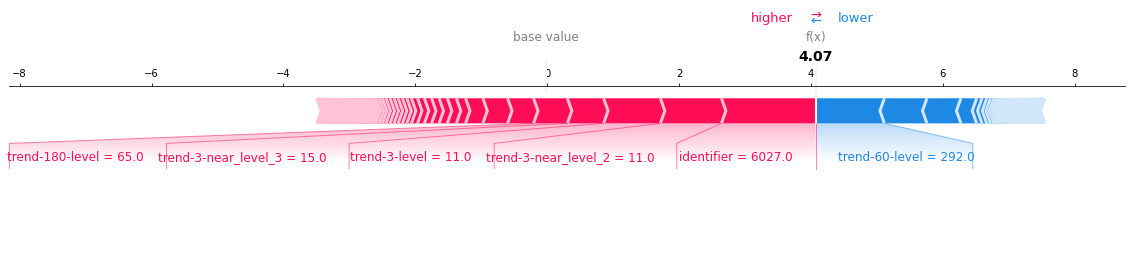

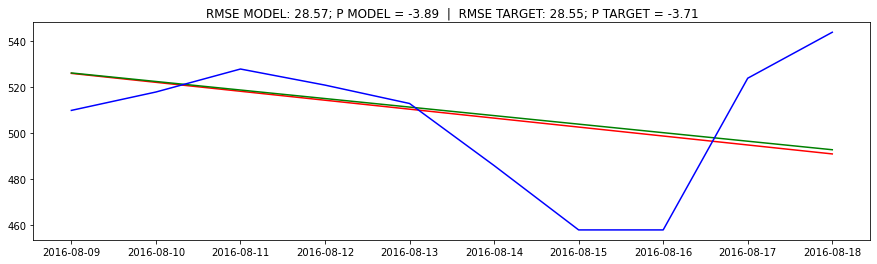

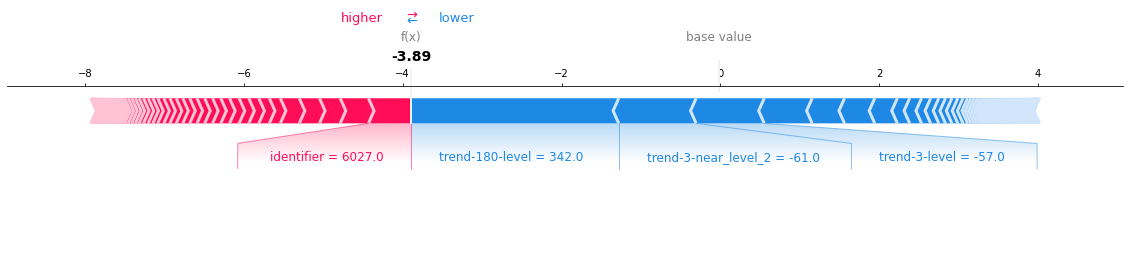

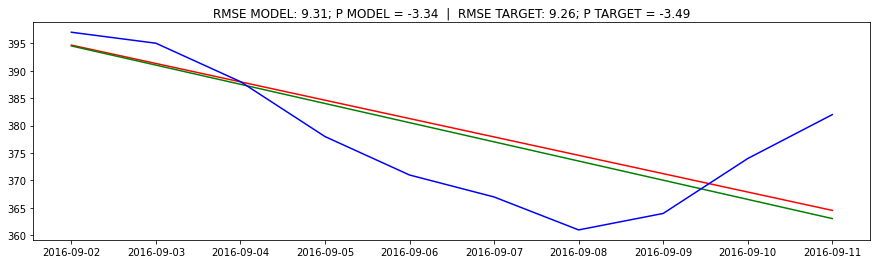

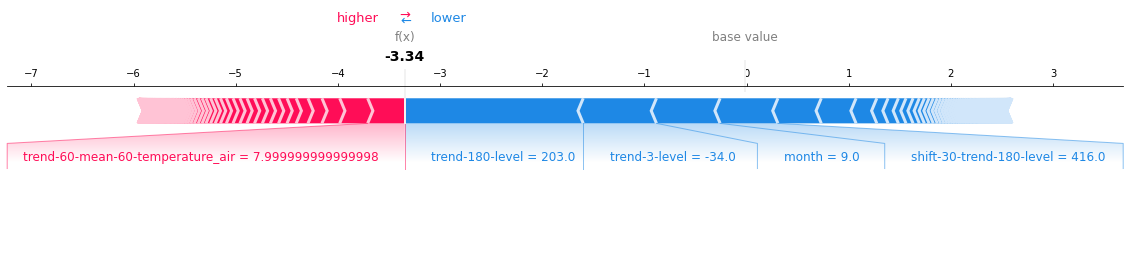

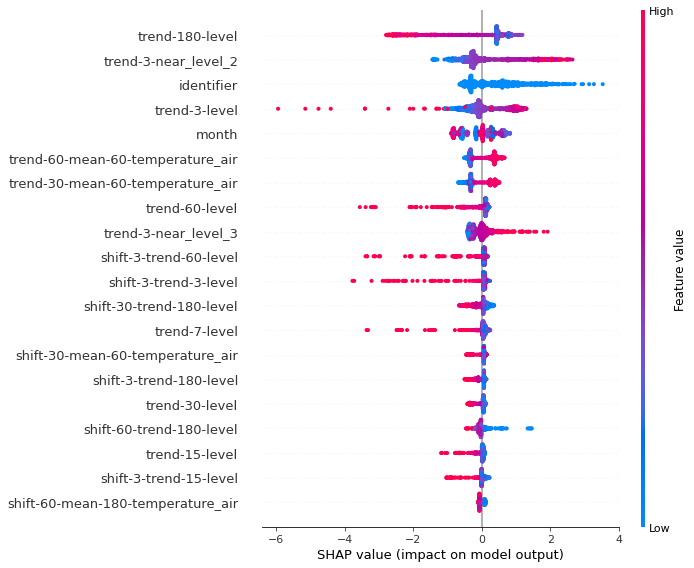



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 5004 ---

Model RMSE: 51.16963801074832
Target RMSE: 18.815883607515747 

Deviations rate:
>10 cm -> 61.0%
>15 cm -> 50.0%
>50 cm -> 21.0%
>60 cm -> 17.0%
>70 cm -> 13.0%
>80 cm -> 11.0%
>90 cm -> 9.0%
>100 cm -> 7.0%
>150 cm -> 3.0%
>170 cm -> 2.0%
>200 cm -> 1.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


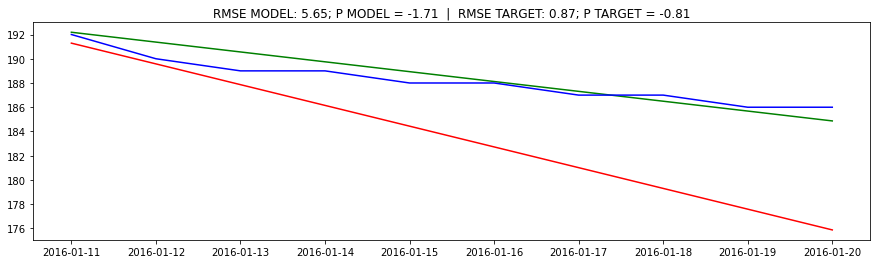

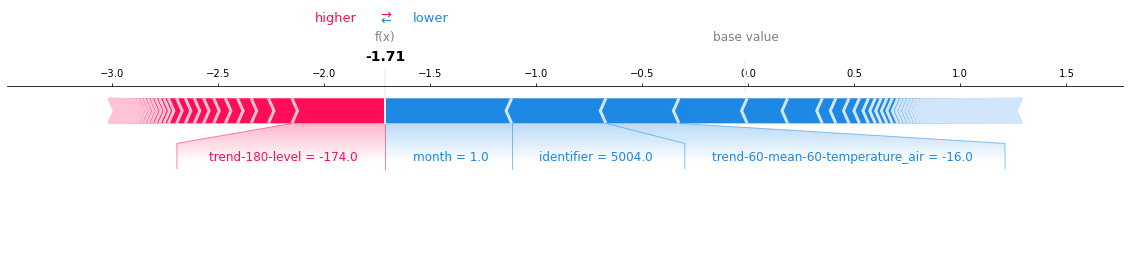

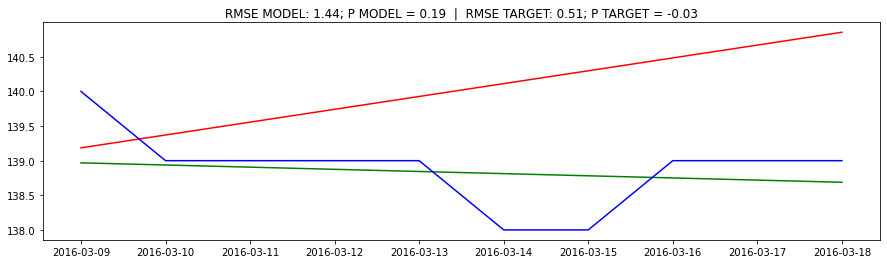

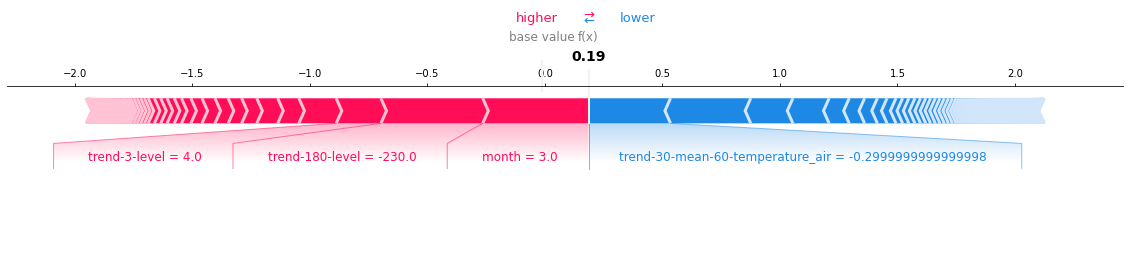

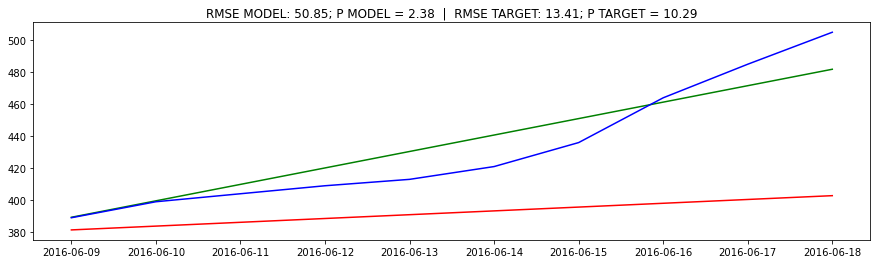

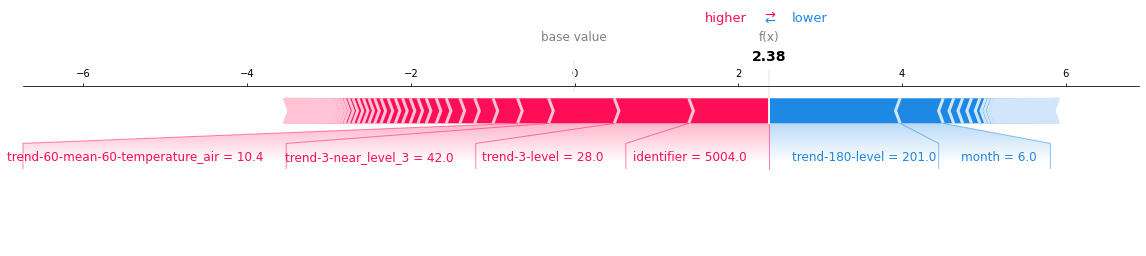

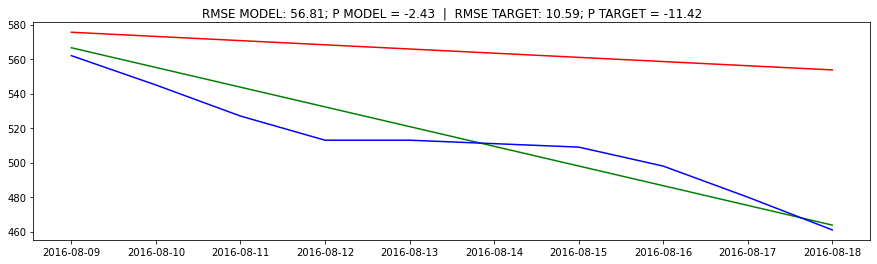

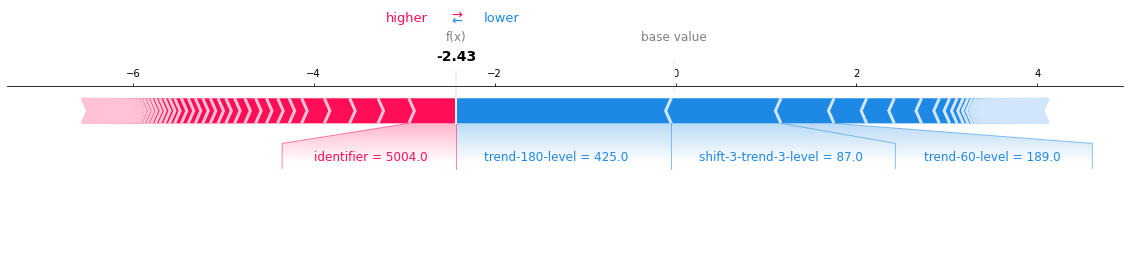

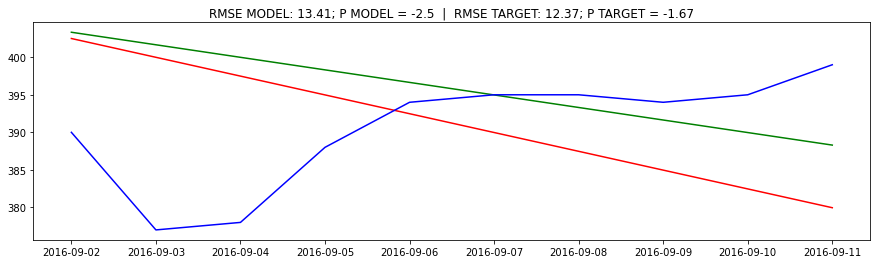

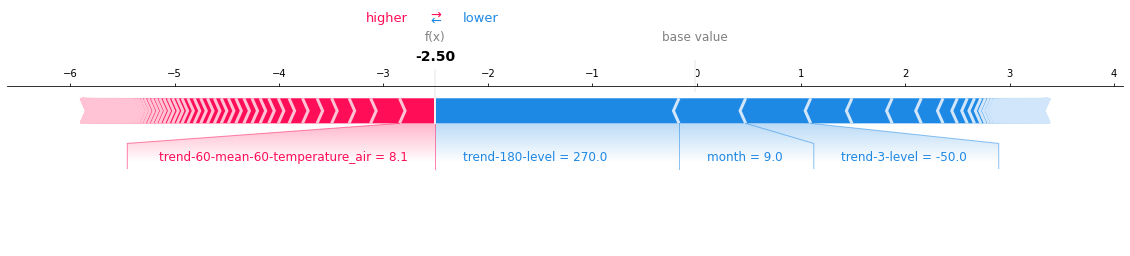

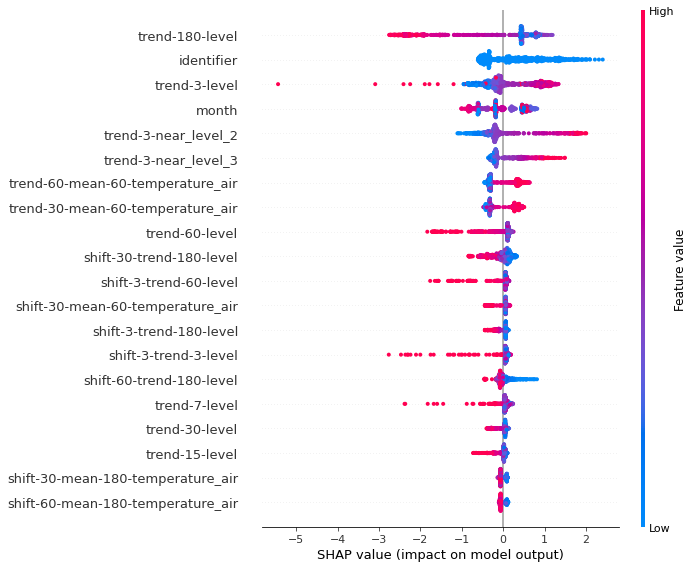



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 5012 ---

Model RMSE: 40.35026177161699
Target RMSE: 13.8081555190201 

Deviations rate:
>10 cm -> 54.0%
>15 cm -> 44.0%
>50 cm -> 15.0%
>60 cm -> 12.0%
>70 cm -> 9.0%
>80 cm -> 7.0%
>90 cm -> 5.0%
>100 cm -> 4.0%
>150 cm -> 1.0%
>170 cm -> 0.0%
>200 cm -> 0.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


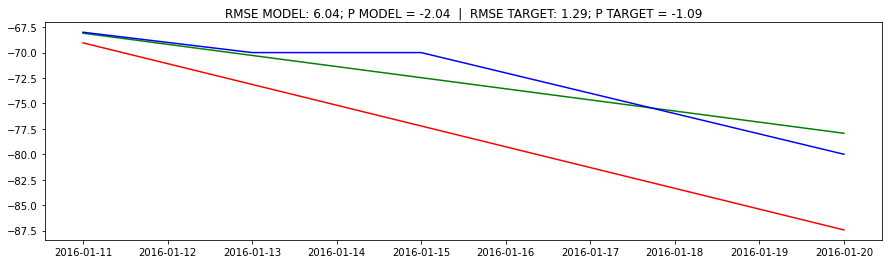

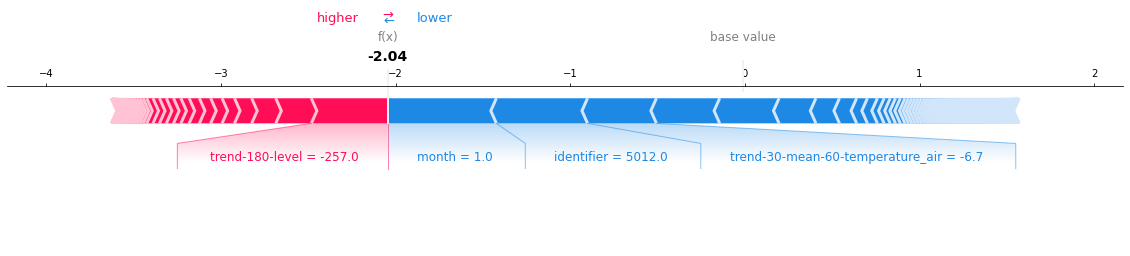

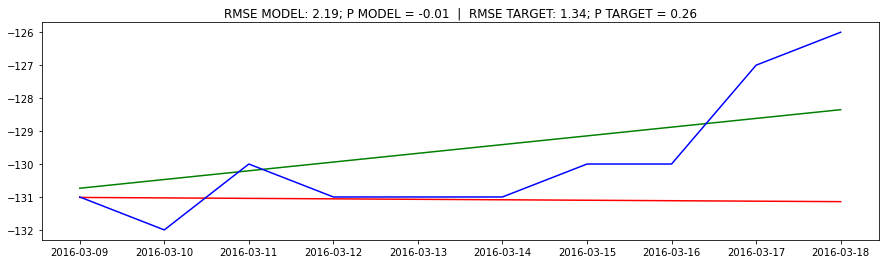

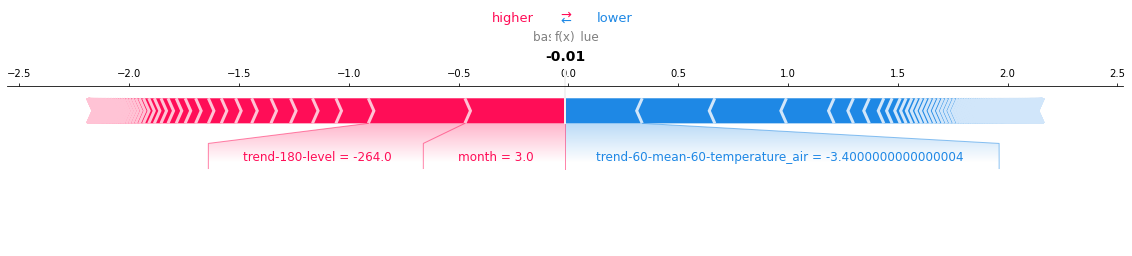

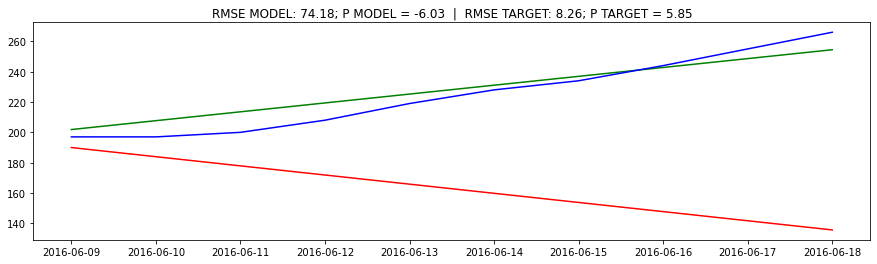

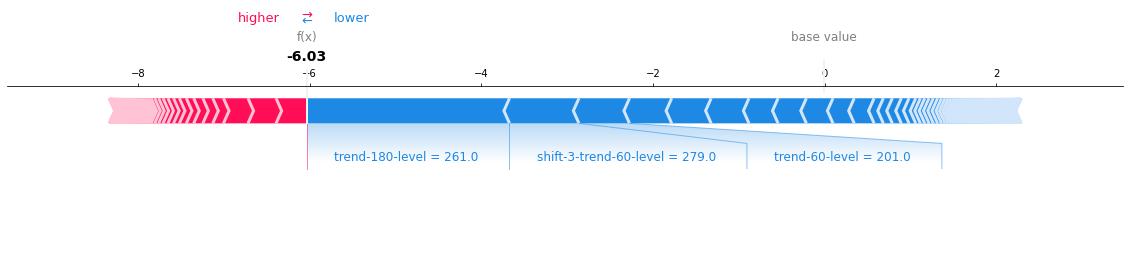

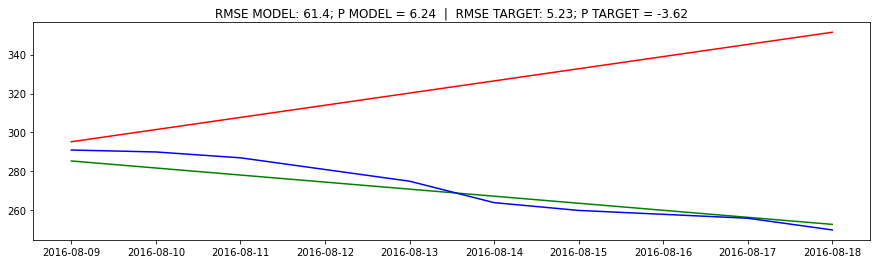

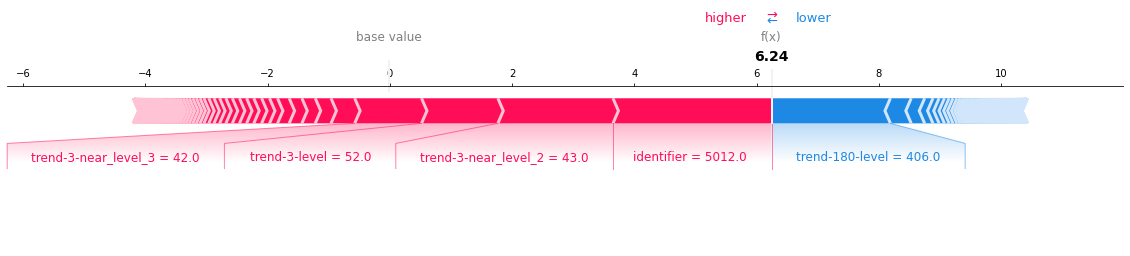

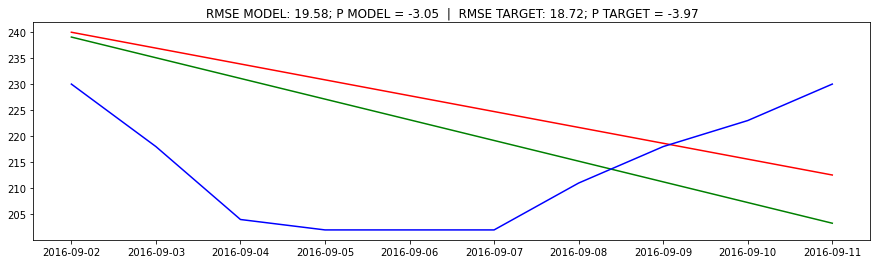

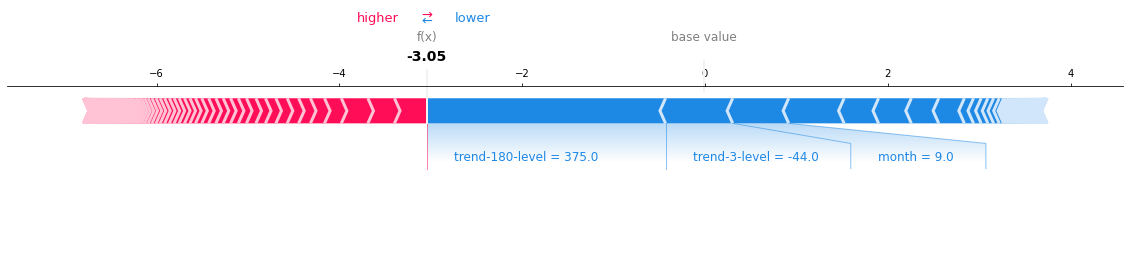

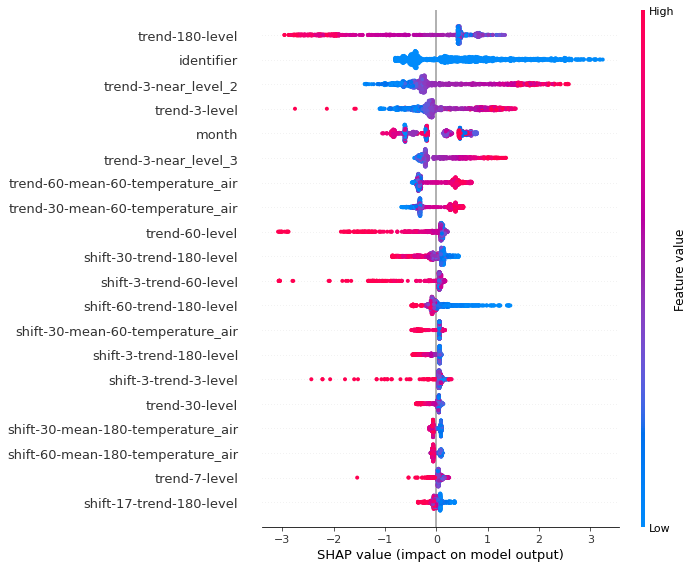



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 5024 ---

Model RMSE: 38.52617154427062
Target RMSE: 12.224505145258204 

Deviations rate:
>10 cm -> 55.0%
>15 cm -> 44.0%
>50 cm -> 14.0%
>60 cm -> 10.0%
>70 cm -> 7.0%
>80 cm -> 5.0%
>90 cm -> 4.0%
>100 cm -> 3.0%
>150 cm -> 1.0%
>170 cm -> 1.0%
>200 cm -> 0.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


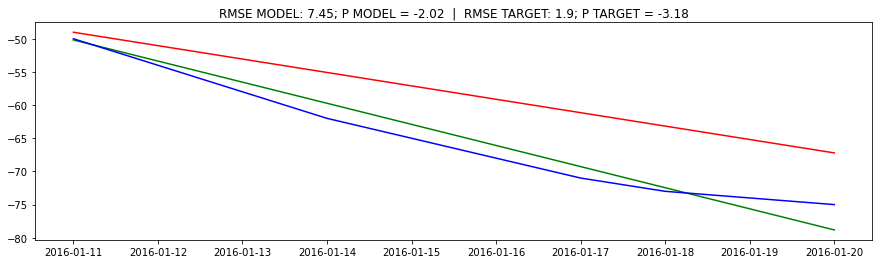

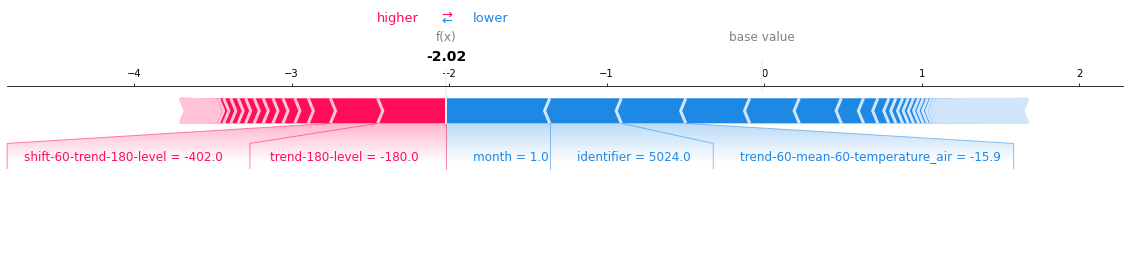

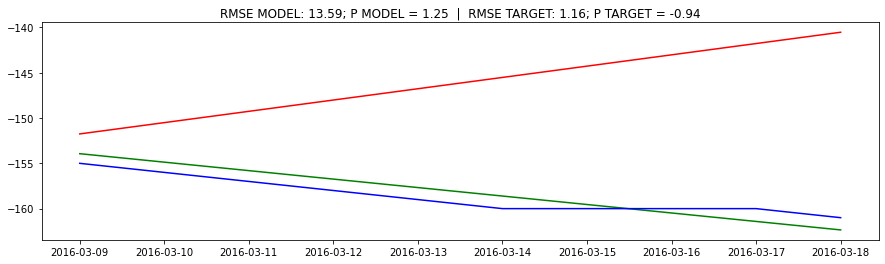

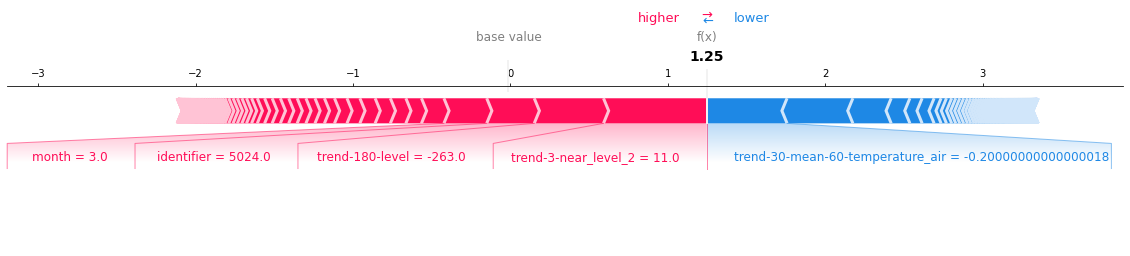

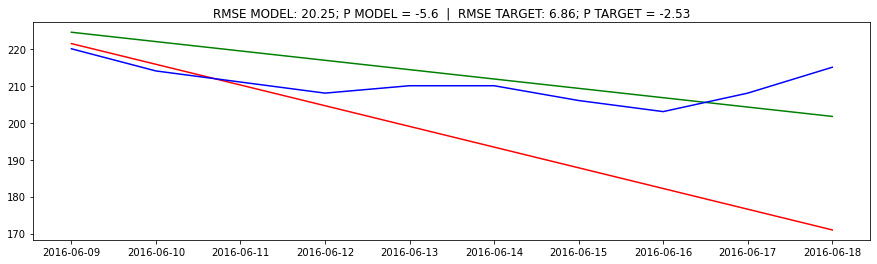

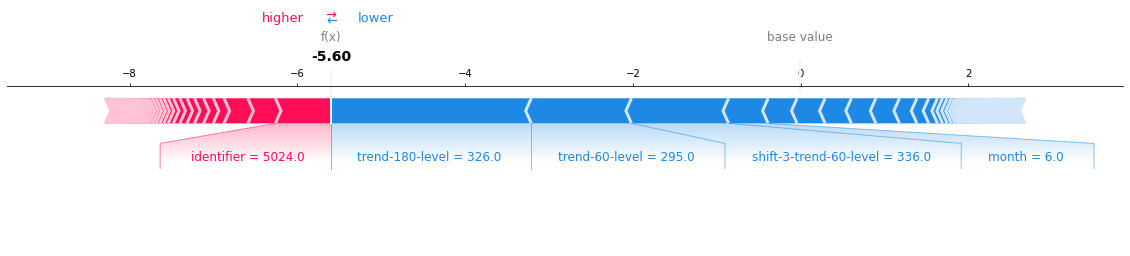

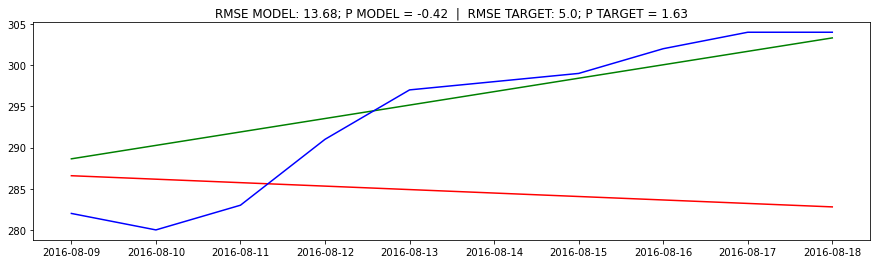

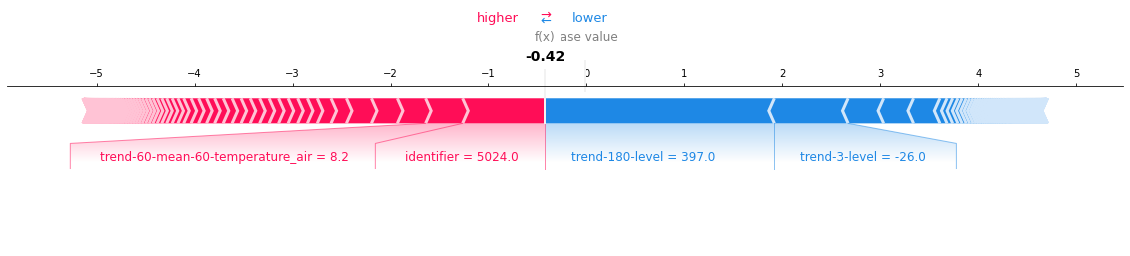

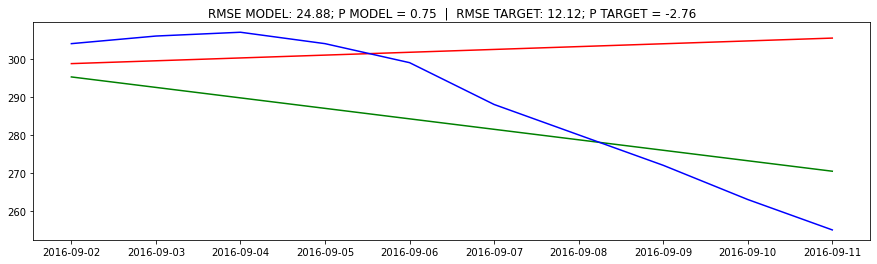

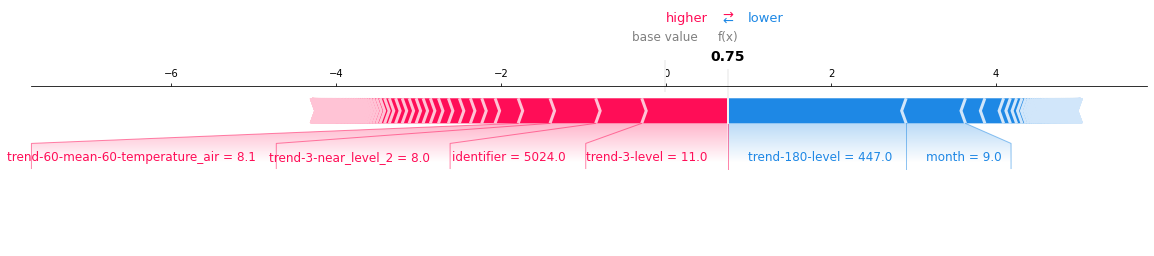

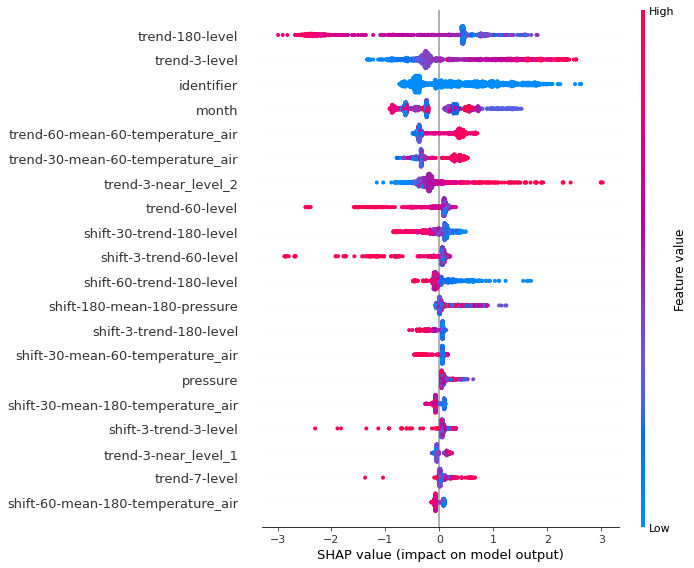



--------------------------------------------------

--- MODEL VALIDATION REPORT FOR STANTION 5805 ---

Model RMSE: 17.295281028622387
Target RMSE: 9.724470232141412 

Deviations rate:
>10 cm -> 50.0%
>15 cm -> 34.0%
>50 cm -> 1.0%
>60 cm -> 0.0%
>70 cm -> 0.0%
>80 cm -> 0.0%
>90 cm -> 0.0%
>100 cm -> 0.0%
>150 cm -> 0.0%
>170 cm -> 0.0%
>200 cm -> 0.0%
>300 cm -> 0.0%
>500 cm -> 0.0%
>1000 cm -> 0.0%


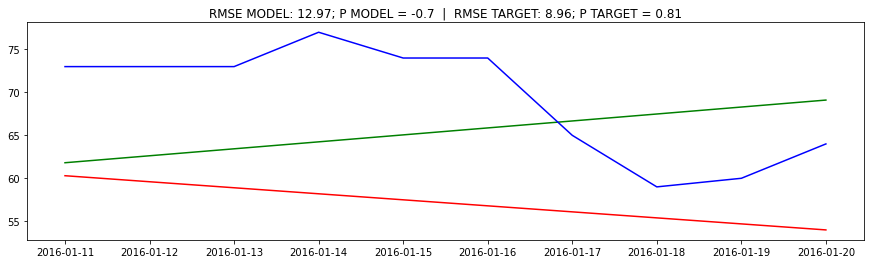

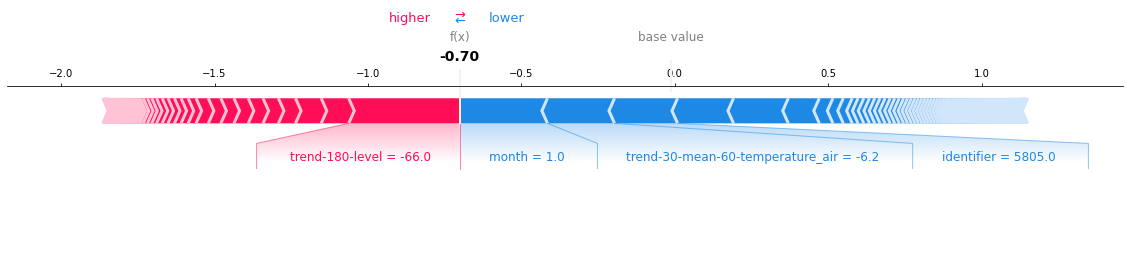

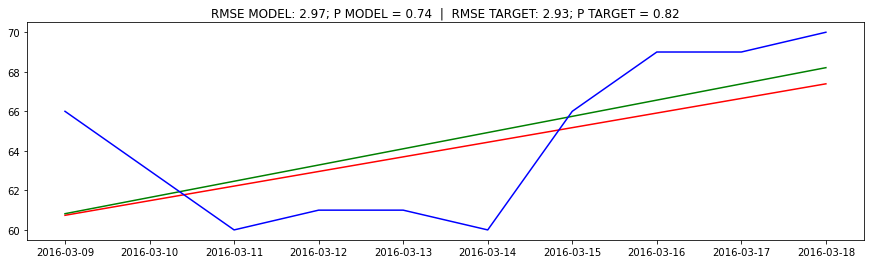

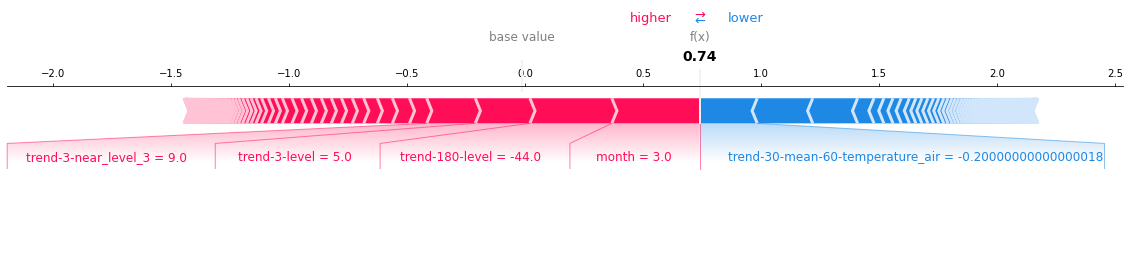

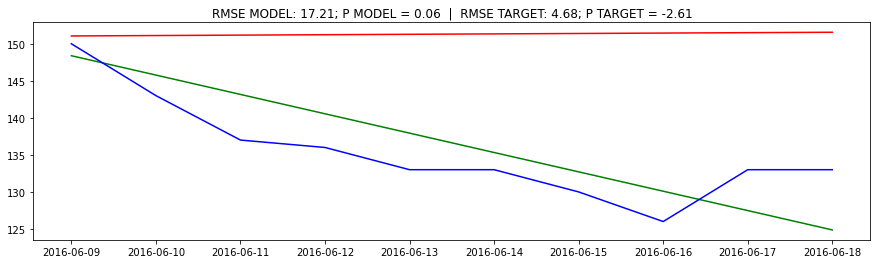

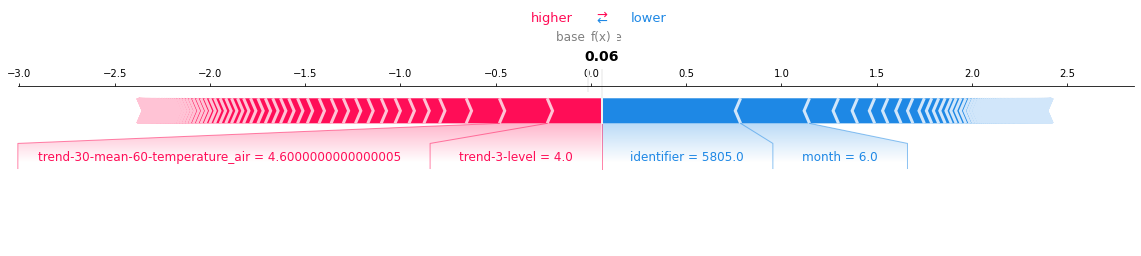

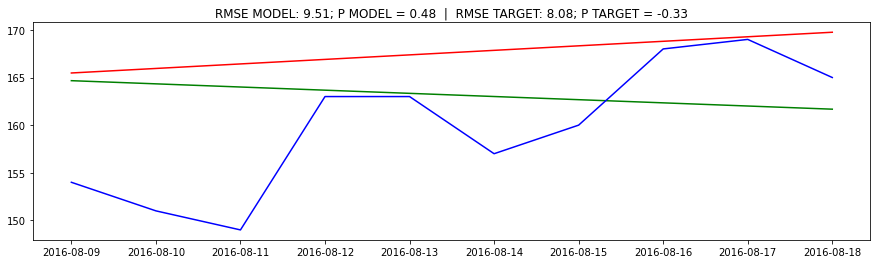

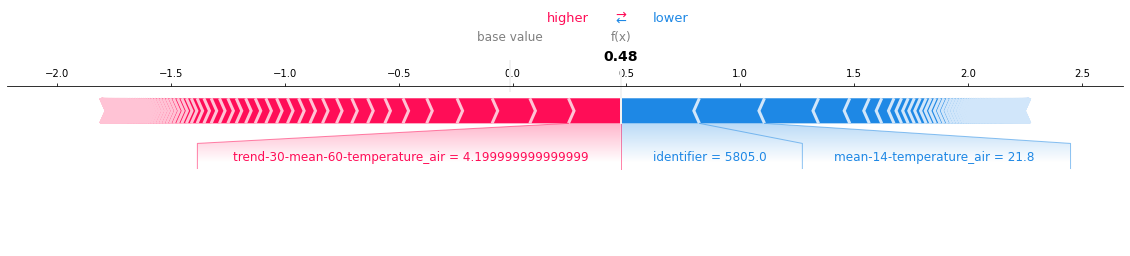

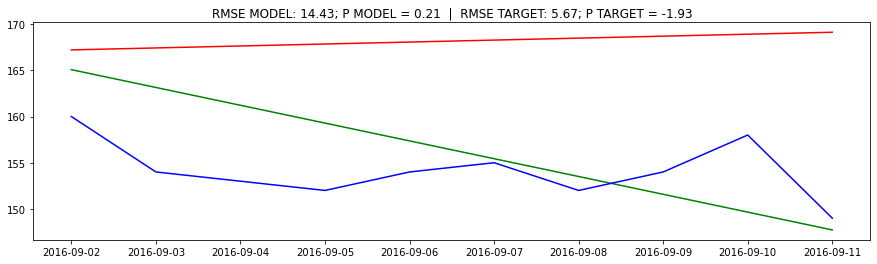

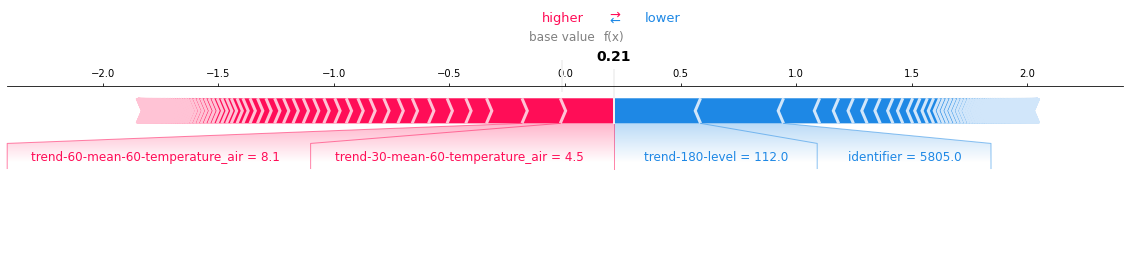

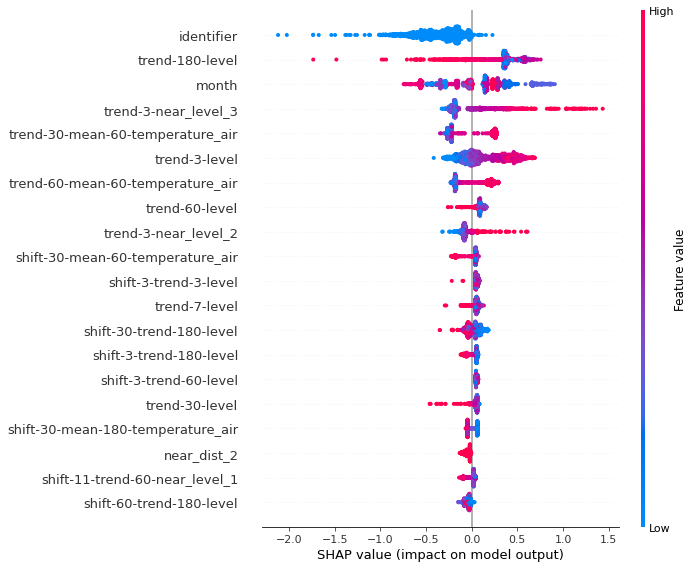


MEAN MODEL RMSE: 45.86209631705474


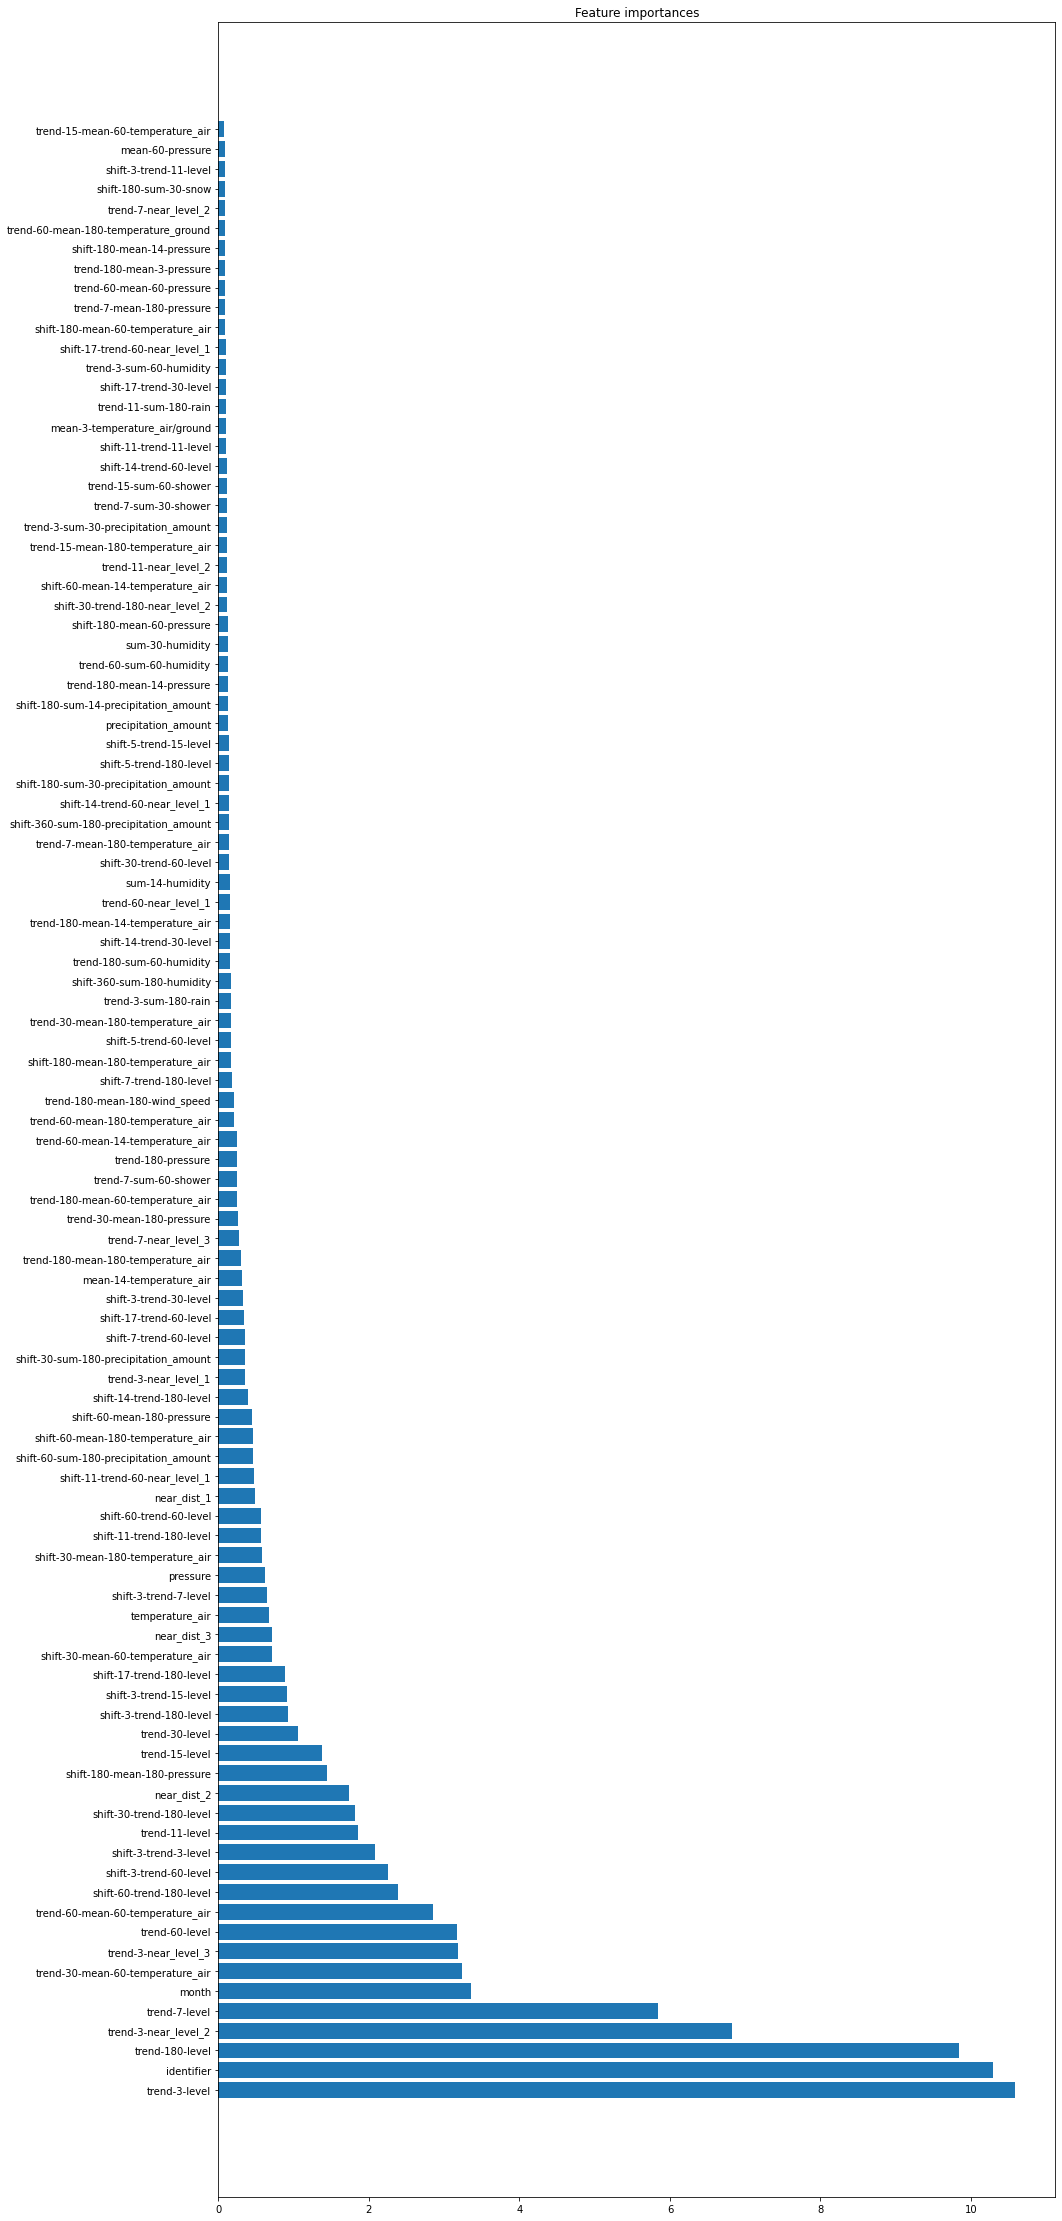

In [71]:
validation_plot_dates = ["10.01.2016", "08.03.2016", "08.06.2016", "08.08.2016", "01.09.2016"]
model_config = {"n_estimators": 1000,
                "max_depth": 5,
                "learning_rate": 0.01,
                "use_best_model": True,
                "cat_features": ["identifier", "month"]
                 }

model = train(processed_data, 
              validation_plot_dates=validation_plot_dates,
              plot_validation_report=True,
              model_config=model_config,
              target_station_ids=target_station_ids,
              split_date="31.12.2015",
              using_features=using_features)

In [72]:
model.save_model("model.catboost")